#Declare the required libraries

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from numpy import *
from IPython.core.debugger import set_trace
import warnings
from random import randrange, sample
import time
warnings.filterwarnings('ignore')

#Softmax Regression

In [ ]:
def one_Hot_Encoder(y, classes):
  y_arr = np.asarray(y, dtype='int32')
  res = np.zeros((len(y_arr), classes))
  res[np.arange(len(y_arr)), y_arr] = 1
  return res

def softmax(z):
  return (np.exp(z).T / np.sum(np.exp(z), axis=1)).T


def avg(x, y, w):
  y_max = np.argmax(x.dot(w), 1)
  return np.mean(np.equal(y, y_max))

def loss_with_Gradient(x, y_oHot, w, reg):
  N,d = x.shape
  z = np.dot(x, w)
  softm = softmax(z)

  loss = -np.log(np.max(softm)) * y_oHot

  reg_Cost = reg/2*np.sum(w*w)

  totalLoss = np.sum(loss)/N + reg_Cost
  prod_hot_prob = np.dot(x.T,(y_oHot - softm))

  gradient = ((-1 / N) * prod_hot_prob) + (reg * w)
  return totalLoss, gradient
  

In [ ]:
class Regression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        self.acc = 0;
        self.total_acc = []

    def fit(self, x_train, x_valid, y_train, y_valid, optimizer):
        if x_train.ndim == 1:
            x_train = x_train[:, None]
            
        if self.add_bias:
            N_train = x_train.shape[0]
            N_valid = x_valid.shape[0]
            x_train = np.column_stack([x_train,np.ones(N_train)])
            x_valid = np.column_stack([x_valid,np.ones(N_valid)])
            
        self.w, self.train_loss, self.valid_loss, self.train_acc, self.valid_acc= optimizer.run(x_train, x_valid, y_train, y_valid)   
        total_val_acc = self.valid_acc[-1]
        
        if self.acc < total_val_acc:
            self.acc = total_val_acc
            self.total_acc.append(total_val_acc)
        return self
    
    def predict(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        accuracy = avg(x, y, self.w)
        
        #print("Best accuracy: " + str(self.acc))
        #rint("Accuracy: " + str(accuracy))

        return accuracy

        

In [ ]:
class GradientDescent:

    def __init__(self, record_history = True, learning_rate=.01, max_iters=100, epsilon=1e-8, batch_size = 2, beta=0.01, reg = 0.001):
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.reg = reg
        self.beta = beta
        self.record_history = record_history
        if record_history:
            self.w_history = []               
          
    def run(self, x_train, x_valid, y_train, y_valid, T=20):
        train_loss_arr = []
        valid_loss_arr = []
        train_acc_arr = []
        valid_acc_arr = []
        loss_arr = []
        D= x_train.shape[1]
        total = np.unique(np.concatenate((y_train, y_valid)))
        classes = len(total)
        self.w = np.zeros((D, classes))
        self.update = np.zeros(self.w.shape)
        y_t_encoded = one_Hot_Encoder(y_train, classes)
        y_v_encoded = one_Hot_Encoder(y_valid, classes) 
        e = 0 
        #Adding additional termination here
        minimum = 0
        K = 0
        #extra termination condition here
        while np.linalg.norm(np.inf) > self.epsilon and e < self.max_iters:
           
            rand_indices = sample(range(x_train.shape[0]), x_train.shape[0])
            x = x_train[rand_indices]
            y = y_t_encoded[rand_indices]

            e += 1

        for i in range(0, x.shape[0], self.batch_size):
            x_batch = x[i:i+self.batch_size]
            y_batch = y[i:i+self.batch_size]


            loss, gradient = loss_with_Gradient(x_batch, y_batch, self.w, self.reg)
            self.update = (self.beta * self.update) + (self.learning_rate * gradient)
            self.w = self.w - self.update
            

            val_accuracy = avg(x_valid, y_valid, self.w)
            if val_accuracy > minimum:
              minimum = val_accuracy
              K = 0
            else:
              K = K + 1
            #Testing if T iterations are complete, then returning the best accuracy here instead!
            if K >= T:
              if self.record_history:
                  train_acc_arr.append(avg(x_train, y_train, self.w))
                  valid_acc_arr.append(val_accuracy)
                  train_loss_arr.append(train_loss_arr)
                  valid_loss_arr.append(valid_loss_arr)

                  return self.w, train_loss_arr, valid_loss_arr, train_acc_arr, valid_acc_arr      
        # save loss and accuracy 
        if self.record_history:
            train_acc_arr.append(avg(x_train, y_train, self.w))
            valid_acc_arr.append(avg(x_valid, y_valid, self.w))
            train_loss_arr.append(train_loss_arr)
            valid_loss_arr.append(valid_loss_arr)
   

      
        return self.w, train_loss_arr, valid_loss_arr, train_acc_arr, valid_acc_arr
        
    

#Analysis

##Creating the folds

In [ ]:
#This function will create the folds
#Must first remove data and target parts out of dataset
def crossValidationFold(data, target):
  size = len(data)
  fold_size = int(size/5)

  #Create folds by splitting datset evenly. The return will be a tuple of (data, target)
  fold1 = data[0:fold_size], target[0:fold_size]
  fold2 = data[(fold_size+1):(fold_size*2)], target[(fold_size+1):(fold_size*2)]
  fold3 = data[(fold_size*2 + 1):(fold_size*3)], target[(fold_size*2 + 1):(fold_size*3)]
  fold4 = data[(fold_size*3 + 1):(fold_size*4)], target[(fold_size*3 + 1):(fold_size*4)]
  fold5 = data[(fold_size*4 + 1): size], target[(fold_size*4 + 1): size]
  
  return [fold1, fold2, fold3, fold4, fold5]

##Hyperparameter Optimization

###Model Execution

In [ ]:
#This function will create a model and run it 5 times with the given params
#This implements the 5-fold cross validation
def modelExecution(dataFolds, learningRate, beta, batchSize, regulizer):
  model = Regression()
  accuracyValidation = []
  accuracyTraining = []
  for i in range(5):
    #First create the validation set
    validData, validTarget = dataFolds[i]

    trainData = []
    trainTarget = []

    #Create training set by adding the rest of the folds into training set
    for j in range(5):
      if i != j:
        tempData, tempTarget = dataFolds[j]

        trainData.extend(tempData)
        trainTarget.extend(tempTarget)

    
    #Can now begin running tests - start with parameters
    optimizer = GradientDescent(learning_rate=learningRate, max_iters=100, record_history=True, beta=beta, batch_size=batchSize, reg=regulizer)

    #Fit models
    model.fit(np.array(trainData), np.array(validData), np.array(trainTarget), np.array(validTarget), optimizer)

    #Run Prediction
    accuracyValidation.append(model.predict(validData, validTarget))
    accuracyTraining.append(model.predict(np.array(trainData), np.array(trainTarget)))

  return accuracyValidation, accuracyTraining


###Setting up the data

In [ ]:
#Import the dataset
digits = load_digits()
iris = fetch_openml(name = 'iris')

#Seperate data and target for shuffling
digitData, digitTarget = digits['data'], digits['target']
irisData, irisTarget = iris['data'], iris['target']

#Preprocessing for irisTarget
#Convert string labels to numerical labels for use in the classifier
irisTargetNumerical = []
labelsIris = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
for i in range(len(irisTarget)):
  for j in range(len(labelsIris)):
    if irisTarget[i] == labelsIris[j]:
      irisTargetNumerical.append(j)

#Shuffle the datasets
digitData, digitTarget = shuffle(digitData, digitTarget)
irisData, irisTarget = shuffle(irisData, irisTargetNumerical)

#Create the 5 folds
digitFolds = crossValidationFold(digitData, digitTarget)
irisFolds = crossValidationFold(irisData, irisTarget)

legend_elements = [Line2D([0], [0], marker='o', color='Blue', label='Validation Accuracy',
                          markerfacecolor='Blue', markersize=8),
                   Line2D([0], [0], marker='o', color='Red', label='Training Accuracy',
                          markerfacecolor='Red', markersize=8)]

###Hyperparameter tuning for Digits

For fold 1 model has validation accuracy 10.58%% and has training accuracy 12.06%
For fold 2 model has validation accuracy 32.40%% and has training accuracy 33.87%
For fold 3 model has validation accuracy 46.37%% and has training accuracy 46.97%
For fold 4 model has validation accuracy 18.16%% and has training accuracy 20.00%
For fold 5 model has validation accuracy 22.78%% and has training accuracy 20.94%


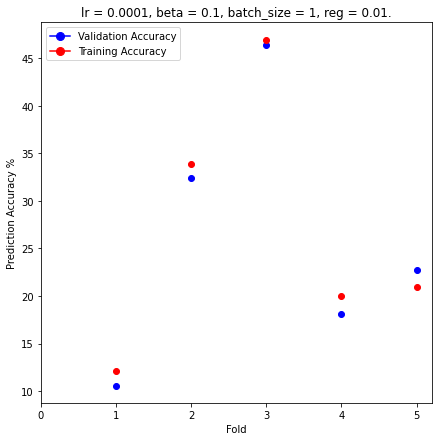


For fold 1 model has validation accuracy 32.87%% and has training accuracy 34.52%
For fold 2 model has validation accuracy 32.96%% and has training accuracy 34.36%
For fold 3 model has validation accuracy 39.94%% and has training accuracy 42.16%
For fold 4 model has validation accuracy 21.79%% and has training accuracy 19.23%
For fold 5 model has validation accuracy 29.17%% and has training accuracy 30.57%


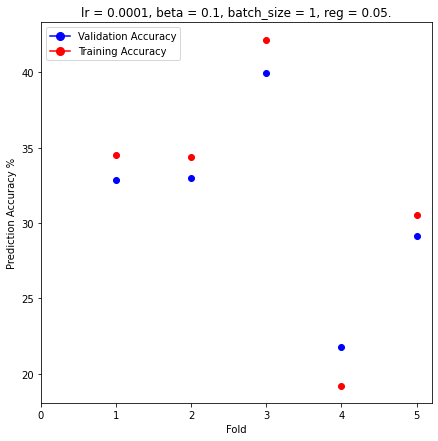


For fold 1 model has validation accuracy 26.18%% and has training accuracy 26.85%
For fold 2 model has validation accuracy 25.98%% and has training accuracy 25.64%
For fold 3 model has validation accuracy 28.49%% and has training accuracy 28.99%
For fold 4 model has validation accuracy 7.54%% and has training accuracy 10.45%
For fold 5 model has validation accuracy 26.94%% and has training accuracy 27.36%


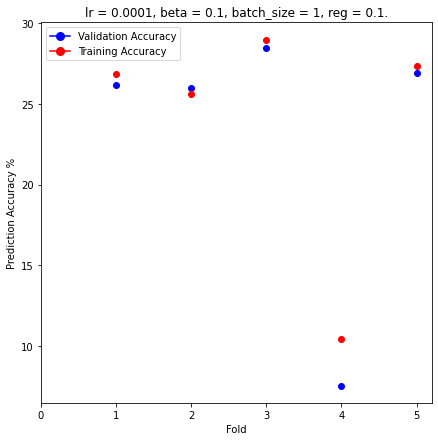


For fold 1 model has validation accuracy 37.05%% and has training accuracy 35.36%
For fold 2 model has validation accuracy 32.68%% and has training accuracy 39.09%
For fold 3 model has validation accuracy 35.47%% and has training accuracy 37.21%
For fold 4 model has validation accuracy 22.07%% and has training accuracy 19.72%
For fold 5 model has validation accuracy 30.56%% and has training accuracy 30.43%


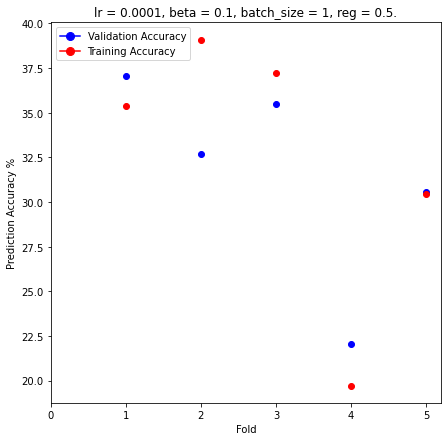


For fold 1 model has validation accuracy 51.25%% and has training accuracy 49.37%
For fold 2 model has validation accuracy 76.82%% and has training accuracy 79.93%
For fold 3 model has validation accuracy 73.74%% and has training accuracy 73.45%
For fold 4 model has validation accuracy 81.84%% and has training accuracy 85.92%
For fold 5 model has validation accuracy 57.78%% and has training accuracy 58.20%


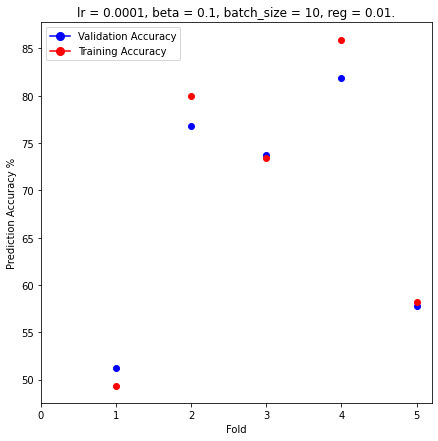


For fold 1 model has validation accuracy 75.21%% and has training accuracy 72.32%
For fold 2 model has validation accuracy 75.14%% and has training accuracy 81.39%
For fold 3 model has validation accuracy 85.20%% and has training accuracy 86.20%
For fold 4 model has validation accuracy 68.99%% and has training accuracy 73.17%
For fold 5 model has validation accuracy 56.11%% and has training accuracy 57.15%


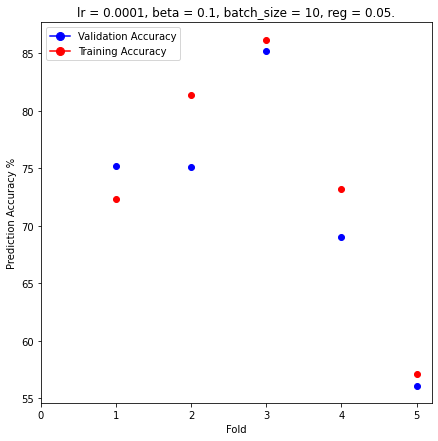


For fold 1 model has validation accuracy 74.37%% and has training accuracy 71.27%
For fold 2 model has validation accuracy 64.80%% and has training accuracy 71.64%
For fold 3 model has validation accuracy 66.48%% and has training accuracy 66.83%
For fold 4 model has validation accuracy 82.12%% and has training accuracy 82.23%
For fold 5 model has validation accuracy 82.22%% and has training accuracy 83.04%


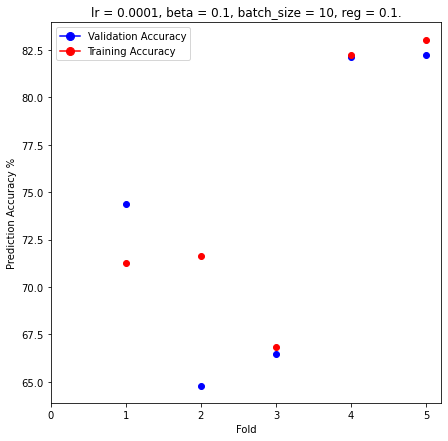


For fold 1 model has validation accuracy 82.17%% and has training accuracy 81.03%
For fold 2 model has validation accuracy 79.33%% and has training accuracy 82.86%
For fold 3 model has validation accuracy 68.16%% and has training accuracy 68.15%
For fold 4 model has validation accuracy 65.08%% and has training accuracy 66.13%
For fold 5 model has validation accuracy 58.06%% and has training accuracy 66.15%


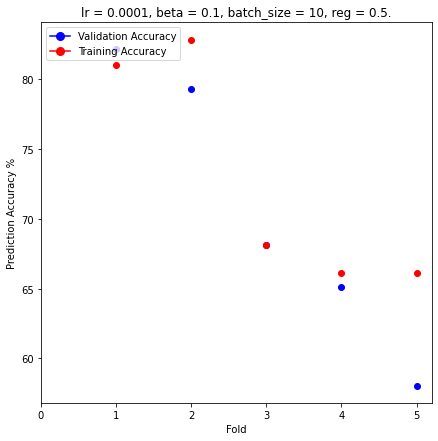


For fold 1 model has validation accuracy 85.24%% and has training accuracy 85.22%
For fold 2 model has validation accuracy 77.65%% and has training accuracy 81.53%
For fold 3 model has validation accuracy 85.47%% and has training accuracy 87.18%
For fold 4 model has validation accuracy 74.86%% and has training accuracy 78.05%
For fold 5 model has validation accuracy 80.83%% and has training accuracy 87.02%


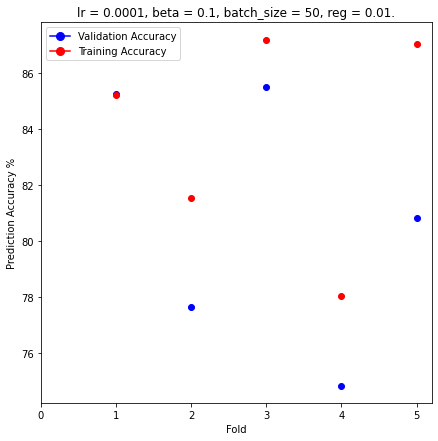


For fold 1 model has validation accuracy 85.79%% and has training accuracy 84.59%
For fold 2 model has validation accuracy 72.91%% and has training accuracy 79.72%
For fold 3 model has validation accuracy 87.15%% and has training accuracy 87.25%
For fold 4 model has validation accuracy 88.55%% and has training accuracy 88.85%
For fold 5 model has validation accuracy 79.72%% and has training accuracy 86.74%


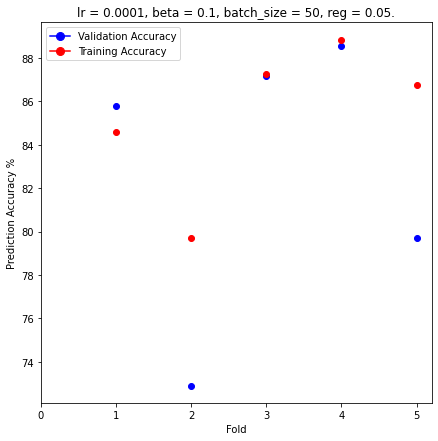


For fold 1 model has validation accuracy 88.02%% and has training accuracy 87.31%
For fold 2 model has validation accuracy 72.35%% and has training accuracy 77.63%
For fold 3 model has validation accuracy 86.87%% and has training accuracy 87.25%
For fold 4 model has validation accuracy 90.50%% and has training accuracy 88.36%
For fold 5 model has validation accuracy 80.56%% and has training accuracy 85.21%


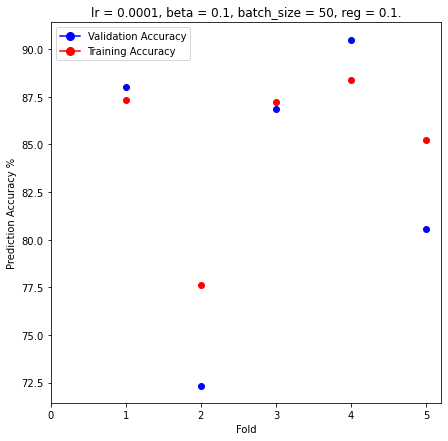


For fold 1 model has validation accuracy 86.91%% and has training accuracy 86.54%
For fold 2 model has validation accuracy 72.63%% and has training accuracy 77.42%
For fold 3 model has validation accuracy 87.15%% and has training accuracy 88.64%
For fold 4 model has validation accuracy 82.68%% and has training accuracy 83.07%
For fold 5 model has validation accuracy 79.44%% and has training accuracy 86.32%


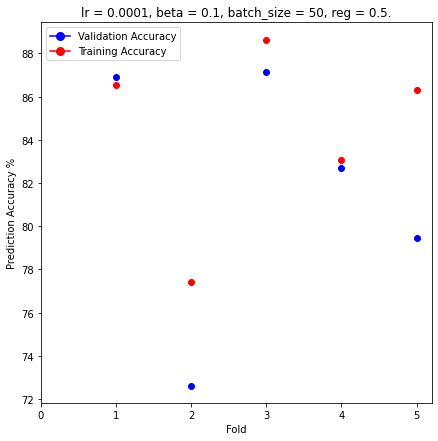


For fold 1 model has validation accuracy 50.97%% and has training accuracy 49.86%
For fold 2 model has validation accuracy 40.50%% and has training accuracy 48.92%
For fold 3 model has validation accuracy 34.08%% and has training accuracy 37.00%
For fold 4 model has validation accuracy 44.97%% and has training accuracy 49.41%
For fold 5 model has validation accuracy 62.50%% and has training accuracy 65.81%


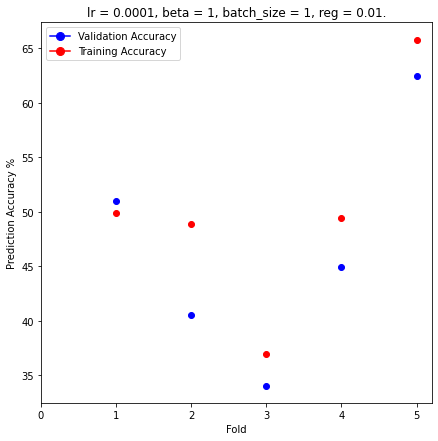


For fold 1 model has validation accuracy 47.35%% and has training accuracy 47.70%
For fold 2 model has validation accuracy 64.80%% and has training accuracy 71.36%
For fold 3 model has validation accuracy 12.57%% and has training accuracy 16.03%
For fold 4 model has validation accuracy 44.69%% and has training accuracy 48.99%
For fold 5 model has validation accuracy 44.72%% and has training accuracy 50.10%


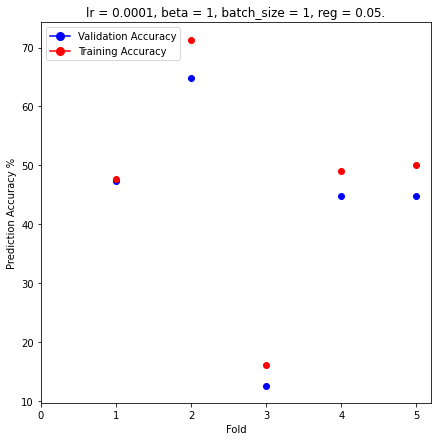


For fold 1 model has validation accuracy 42.06%% and has training accuracy 37.31%
For fold 2 model has validation accuracy 66.20%% and has training accuracy 61.39%
For fold 3 model has validation accuracy 54.75%% and has training accuracy 50.31%
For fold 4 model has validation accuracy 51.68%% and has training accuracy 53.45%
For fold 5 model has validation accuracy 50.00%% and has training accuracy 47.38%


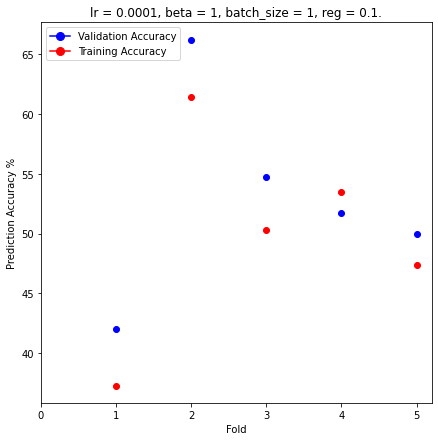


For fold 1 model has validation accuracy 59.89%% and has training accuracy 58.30%
For fold 2 model has validation accuracy 57.54%% and has training accuracy 62.65%
For fold 3 model has validation accuracy 44.97%% and has training accuracy 44.39%
For fold 4 model has validation accuracy 71.23%% and has training accuracy 71.43%
For fold 5 model has validation accuracy 42.78%% and has training accuracy 41.38%


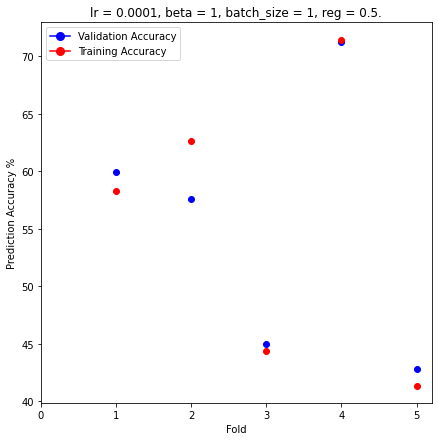


For fold 1 model has validation accuracy 90.25%% and has training accuracy 90.17%
For fold 2 model has validation accuracy 78.21%% and has training accuracy 82.72%
For fold 3 model has validation accuracy 90.50%% and has training accuracy 90.87%
For fold 4 model has validation accuracy 87.15%% and has training accuracy 88.57%
For fold 5 model has validation accuracy 89.72%% and has training accuracy 91.00%


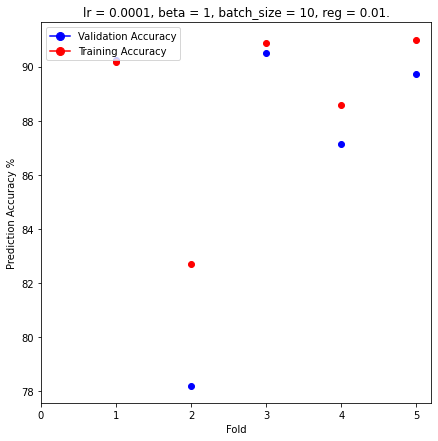


For fold 1 model has validation accuracy 91.09%% and has training accuracy 89.96%
For fold 2 model has validation accuracy 79.61%% and has training accuracy 81.88%
For fold 3 model has validation accuracy 86.03%% and has training accuracy 86.62%
For fold 4 model has validation accuracy 86.87%% and has training accuracy 86.83%
For fold 5 model has validation accuracy 83.89%% and has training accuracy 88.07%


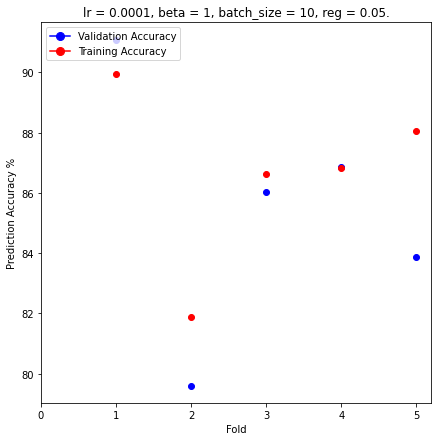


For fold 1 model has validation accuracy 87.74%% and has training accuracy 87.87%
For fold 2 model has validation accuracy 85.20%% and has training accuracy 86.97%
For fold 3 model has validation accuracy 87.99%% and has training accuracy 90.73%
For fold 4 model has validation accuracy 92.74%% and has training accuracy 92.26%
For fold 5 model has validation accuracy 80.00%% and has training accuracy 84.93%


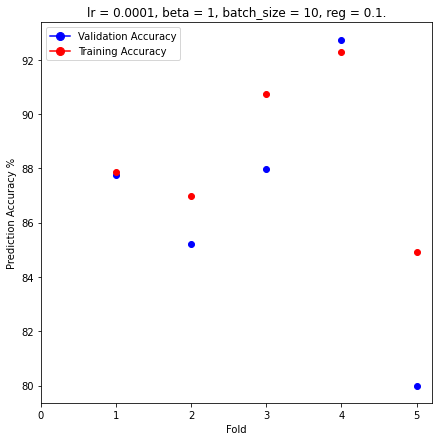


For fold 1 model has validation accuracy 91.64%% and has training accuracy 89.89%
For fold 2 model has validation accuracy 87.71%% and has training accuracy 88.78%
For fold 3 model has validation accuracy 89.11%% and has training accuracy 89.27%
For fold 4 model has validation accuracy 89.11%% and has training accuracy 87.60%
For fold 5 model has validation accuracy 84.72%% and has training accuracy 88.56%


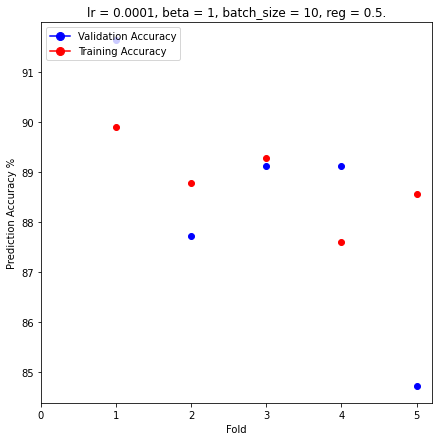


For fold 1 model has validation accuracy 87.47%% and has training accuracy 86.54%
For fold 2 model has validation accuracy 84.64%% and has training accuracy 86.97%
For fold 3 model has validation accuracy 88.55%% and has training accuracy 89.76%
For fold 4 model has validation accuracy 83.24%% and has training accuracy 84.11%
For fold 5 model has validation accuracy 85.00%% and has training accuracy 87.86%


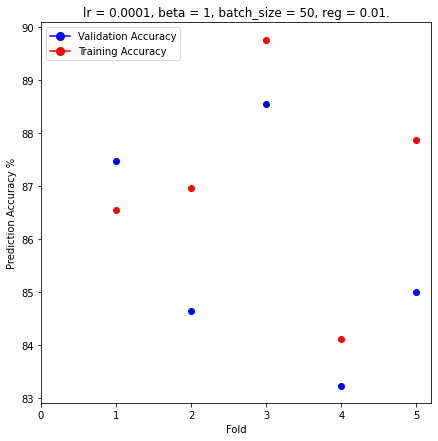


For fold 1 model has validation accuracy 89.69%% and has training accuracy 86.61%
For fold 2 model has validation accuracy 75.98%% and has training accuracy 80.70%
For fold 3 model has validation accuracy 85.47%% and has training accuracy 83.62%
For fold 4 model has validation accuracy 86.59%% and has training accuracy 87.74%
For fold 5 model has validation accuracy 84.17%% and has training accuracy 85.83%


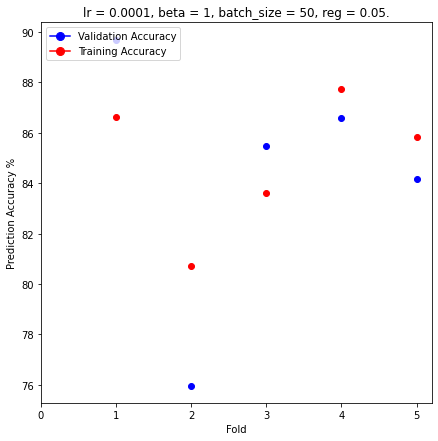


For fold 1 model has validation accuracy 86.35%% and has training accuracy 84.45%
For fold 2 model has validation accuracy 87.71%% and has training accuracy 87.46%
For fold 3 model has validation accuracy 87.15%% and has training accuracy 87.18%
For fold 4 model has validation accuracy 89.66%% and has training accuracy 90.66%
For fold 5 model has validation accuracy 82.22%% and has training accuracy 85.14%


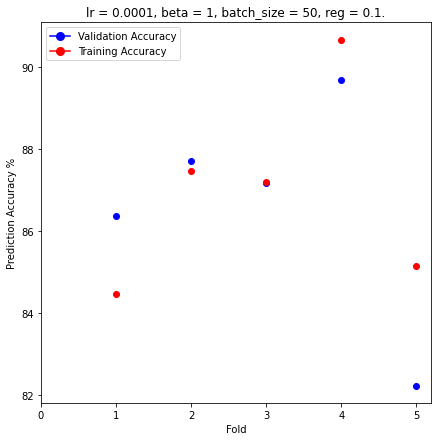


For fold 1 model has validation accuracy 82.45%% and has training accuracy 81.94%
For fold 2 model has validation accuracy 77.65%% and has training accuracy 84.32%
For fold 3 model has validation accuracy 87.71%% and has training accuracy 86.48%
For fold 4 model has validation accuracy 88.83%% and has training accuracy 88.50%
For fold 5 model has validation accuracy 80.56%% and has training accuracy 83.18%


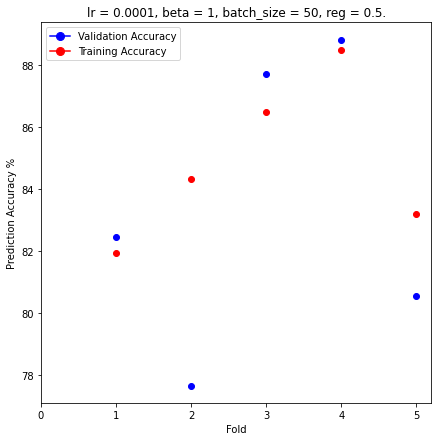


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


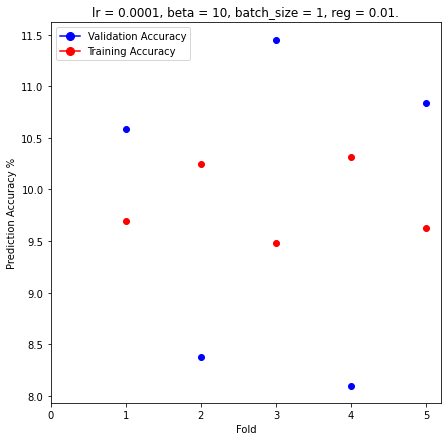


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


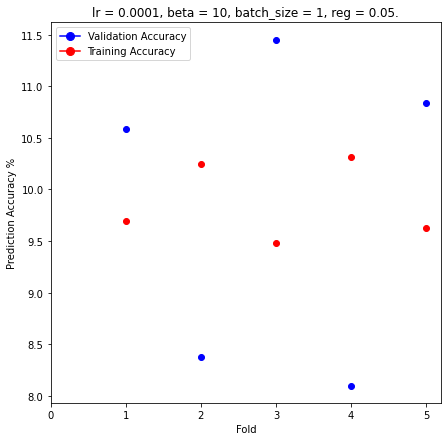


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


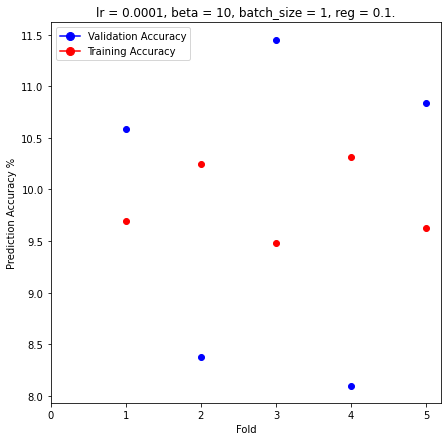


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


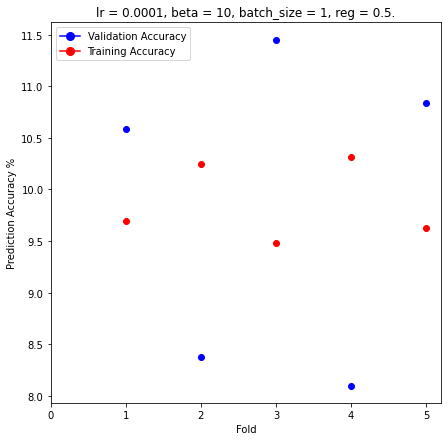


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


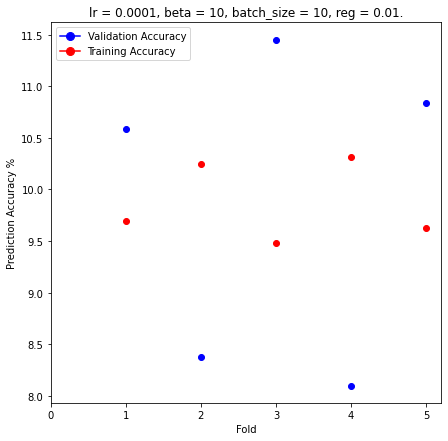


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


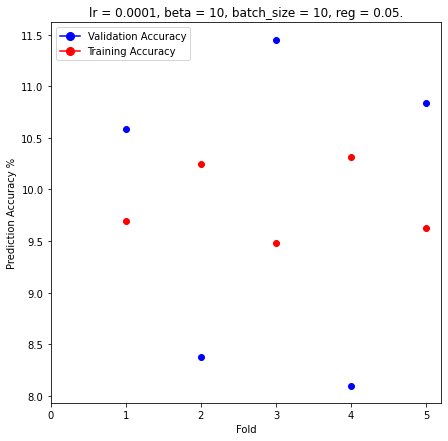


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


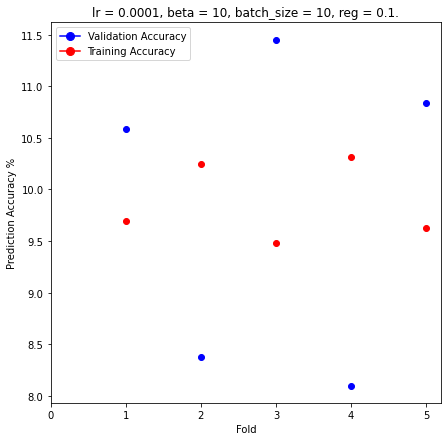


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


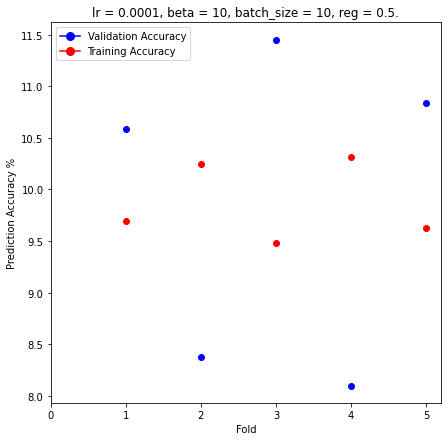


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


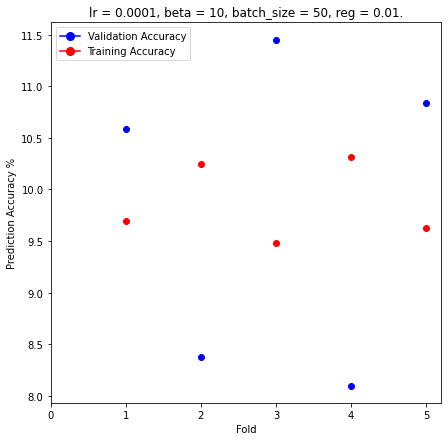


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


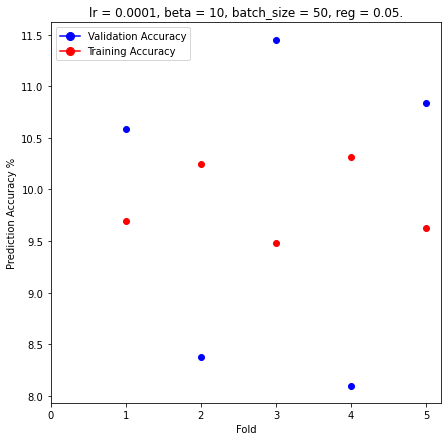


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%



For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


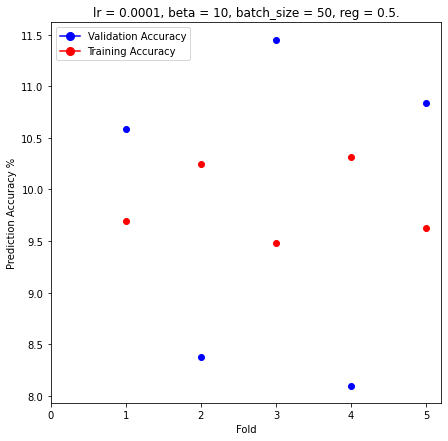


For fold 1 model has validation accuracy 66.02%% and has training accuracy 64.78%
For fold 2 model has validation accuracy 42.18%% and has training accuracy 46.90%
For fold 3 model has validation accuracy 23.46%% and has training accuracy 23.34%
For fold 4 model has validation accuracy 64.25%% and has training accuracy 64.67%
For fold 5 model has validation accuracy 75.28%% and has training accuracy 77.53%


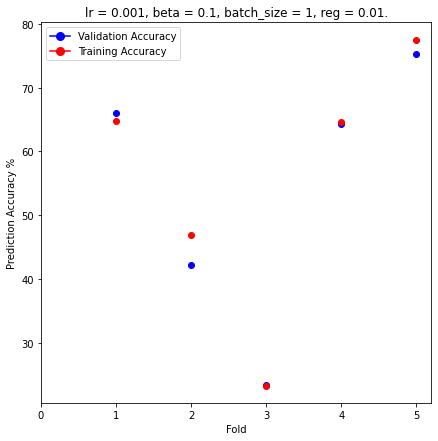


For fold 1 model has validation accuracy 67.97%% and has training accuracy 65.62%
For fold 2 model has validation accuracy 51.12%% and has training accuracy 53.73%
For fold 3 model has validation accuracy 65.92%% and has training accuracy 64.25%
For fold 4 model has validation accuracy 46.65%% and has training accuracy 46.69%
For fold 5 model has validation accuracy 56.39%% and has training accuracy 55.76%


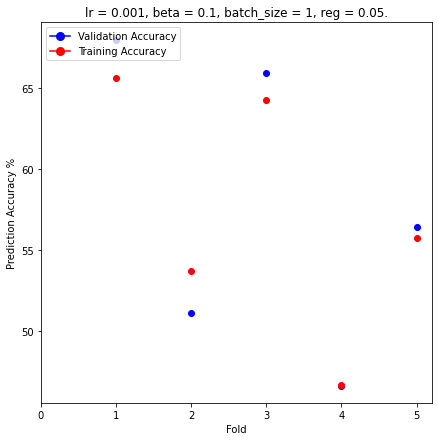


For fold 1 model has validation accuracy 37.05%% and has training accuracy 38.42%
For fold 2 model has validation accuracy 58.66%% and has training accuracy 59.23%
For fold 3 model has validation accuracy 35.47%% and has training accuracy 36.52%
For fold 4 model has validation accuracy 45.53%% and has training accuracy 48.99%
For fold 5 model has validation accuracy 27.78%% and has training accuracy 26.03%


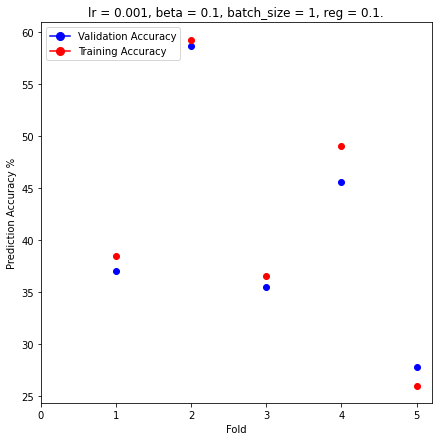


For fold 1 model has validation accuracy 48.19%% and has training accuracy 50.35%
For fold 2 model has validation accuracy 82.96%% and has training accuracy 85.57%
For fold 3 model has validation accuracy 59.78%% and has training accuracy 59.23%
For fold 4 model has validation accuracy 67.60%% and has training accuracy 71.99%
For fold 5 model has validation accuracy 73.89%% and has training accuracy 77.88%


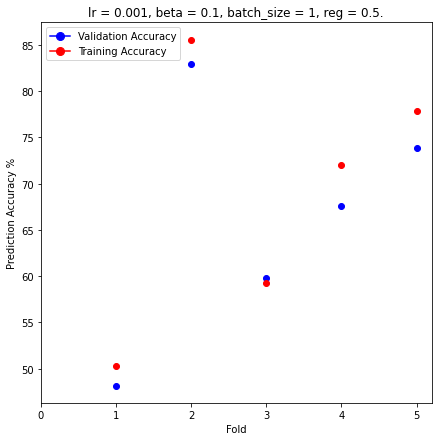


For fold 1 model has validation accuracy 88.86%% and has training accuracy 87.52%
For fold 2 model has validation accuracy 80.73%% and has training accuracy 85.78%
For fold 3 model has validation accuracy 88.55%% and has training accuracy 90.24%
For fold 4 model has validation accuracy 91.06%% and has training accuracy 92.68%
For fold 5 model has validation accuracy 89.17%% and has training accuracy 92.18%


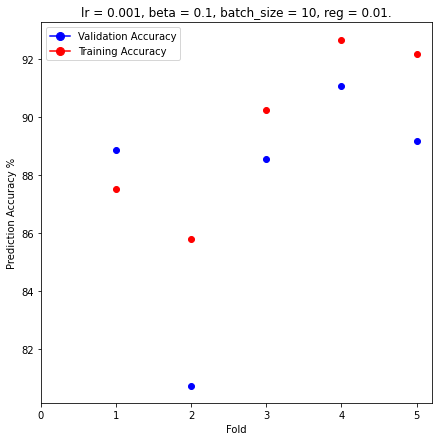


For fold 1 model has validation accuracy 91.92%% and has training accuracy 91.35%
For fold 2 model has validation accuracy 70.67%% and has training accuracy 73.03%
For fold 3 model has validation accuracy 84.92%% and has training accuracy 87.25%
For fold 4 model has validation accuracy 92.46%% and has training accuracy 91.50%
For fold 5 model has validation accuracy 88.33%% and has training accuracy 90.23%


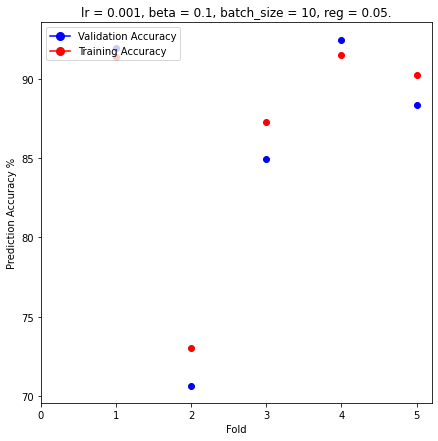


For fold 1 model has validation accuracy 91.09%% and has training accuracy 90.86%
For fold 2 model has validation accuracy 89.94%% and has training accuracy 90.59%
For fold 3 model has validation accuracy 73.46%% and has training accuracy 74.91%
For fold 4 model has validation accuracy 91.62%% and has training accuracy 90.94%
For fold 5 model has validation accuracy 86.94%% and has training accuracy 89.74%


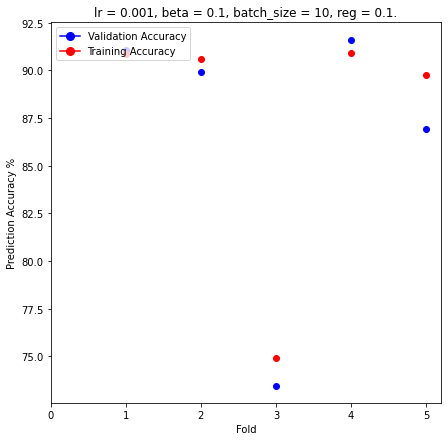


For fold 1 model has validation accuracy 87.19%% and has training accuracy 85.70%
For fold 2 model has validation accuracy 88.83%% and has training accuracy 90.24%
For fold 3 model has validation accuracy 89.66%% and has training accuracy 88.43%
For fold 4 model has validation accuracy 89.94%% and has training accuracy 90.45%
For fold 5 model has validation accuracy 89.44%% and has training accuracy 91.63%


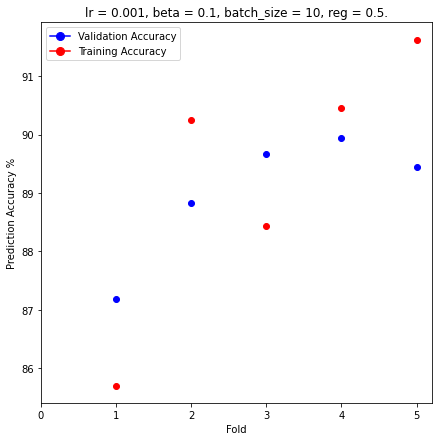


For fold 1 model has validation accuracy 89.69%% and has training accuracy 88.49%
For fold 2 model has validation accuracy 84.64%% and has training accuracy 84.25%
For fold 3 model has validation accuracy 86.31%% and has training accuracy 83.41%
For fold 4 model has validation accuracy 87.99%% and has training accuracy 86.55%
For fold 5 model has validation accuracy 87.50%% and has training accuracy 89.25%


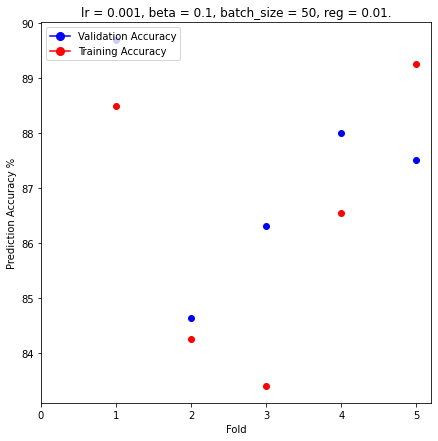


For fold 1 model has validation accuracy 86.63%% and has training accuracy 85.22%
For fold 2 model has validation accuracy 83.80%% and has training accuracy 85.09%
For fold 3 model has validation accuracy 87.71%% and has training accuracy 88.22%
For fold 4 model has validation accuracy 87.99%% and has training accuracy 86.90%
For fold 5 model has validation accuracy 84.44%% and has training accuracy 88.35%


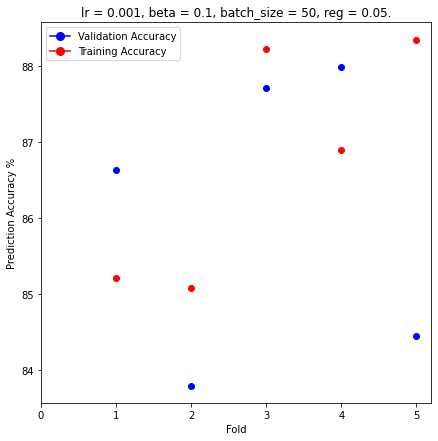


For fold 1 model has validation accuracy 90.25%% and has training accuracy 89.26%
For fold 2 model has validation accuracy 87.99%% and has training accuracy 88.43%
For fold 3 model has validation accuracy 87.15%% and has training accuracy 87.67%
For fold 4 model has validation accuracy 86.87%% and has training accuracy 87.94%
For fold 5 model has validation accuracy 84.72%% and has training accuracy 88.07%


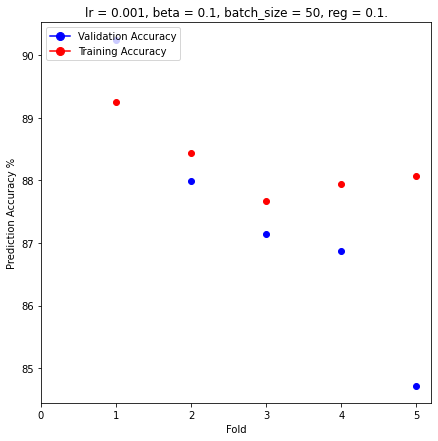


For fold 1 model has validation accuracy 89.97%% and has training accuracy 89.47%
For fold 2 model has validation accuracy 78.77%% and has training accuracy 85.16%
For fold 3 model has validation accuracy 88.55%% and has training accuracy 86.62%
For fold 4 model has validation accuracy 90.22%% and has training accuracy 89.20%
For fold 5 model has validation accuracy 81.11%% and has training accuracy 84.58%


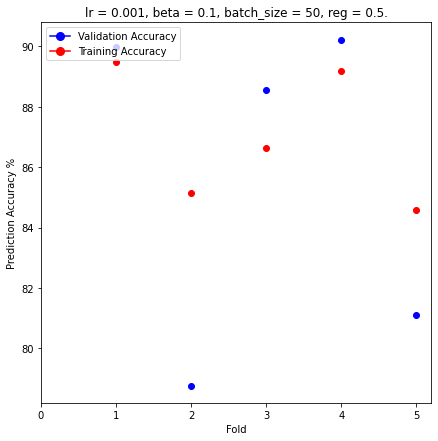


For fold 1 model has validation accuracy 46.24%% and has training accuracy 44.56%
For fold 2 model has validation accuracy 22.35%% and has training accuracy 23.76%
For fold 3 model has validation accuracy 54.47%% and has training accuracy 57.28%
For fold 4 model has validation accuracy 38.55%% and has training accuracy 37.84%
For fold 5 model has validation accuracy 42.78%% and has training accuracy 44.38%


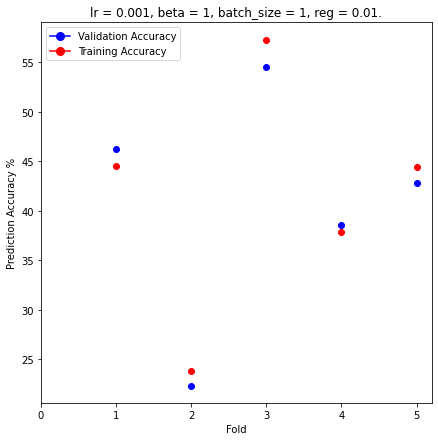


For fold 1 model has validation accuracy 43.18%% and has training accuracy 40.52%
For fold 2 model has validation accuracy 32.40%% and has training accuracy 35.75%
For fold 3 model has validation accuracy 27.37%% and has training accuracy 28.08%
For fold 4 model has validation accuracy 39.66%% and has training accuracy 49.41%
For fold 5 model has validation accuracy 25.28%% and has training accuracy 23.52%


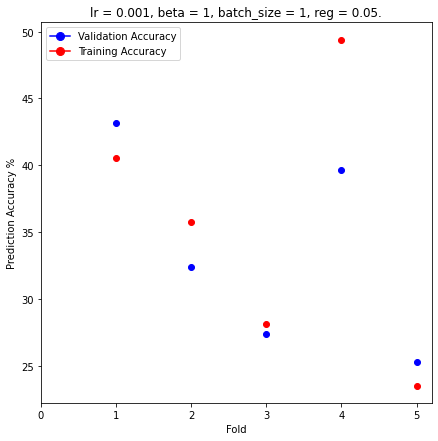


For fold 1 model has validation accuracy 40.67%% and has training accuracy 38.77%
For fold 2 model has validation accuracy 35.47%% and has training accuracy 37.28%
For fold 3 model has validation accuracy 45.25%% and has training accuracy 47.60%
For fold 4 model has validation accuracy 33.52%% and has training accuracy 35.40%
For fold 5 model has validation accuracy 51.94%% and has training accuracy 52.83%


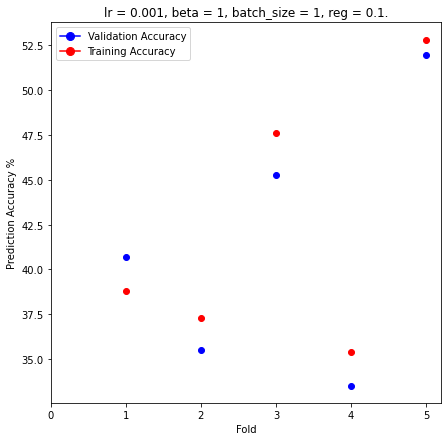


For fold 1 model has validation accuracy 42.90%% and has training accuracy 46.16%
For fold 2 model has validation accuracy 25.14%% and has training accuracy 25.64%
For fold 3 model has validation accuracy 35.47%% and has training accuracy 38.12%
For fold 4 model has validation accuracy 39.66%% and has training accuracy 41.39%
For fold 5 model has validation accuracy 37.78%% and has training accuracy 35.10%



For fold 1 model has validation accuracy 88.58%% and has training accuracy 88.56%
For fold 2 model has validation accuracy 80.17%% and has training accuracy 82.65%
For fold 3 model has validation accuracy 87.71%% and has training accuracy 87.67%
For fold 4 model has validation accuracy 82.40%% and has training accuracy 83.90%
For fold 5 model has validation accuracy 84.17%% and has training accuracy 86.95%



For fold 1 model has validation accuracy 91.09%% and has training accuracy 89.12%
For fold 2 model has validation accuracy 91.62%% and has training accuracy 93.17%
For fold 3 model has validation accuracy 85.75%% and has training accuracy 86.55%
For fold 4 model has validation accuracy 86.87%% and has training accuracy 87.67%
For fold 5 model has validation accuracy 85.56%% and has training accuracy 86.95%



For fold 1 model has validation accuracy 86.07%% and has training accuracy 84.80%
For fold 2 model has validation accuracy 85.20%% and has training accuracy 86.34%
For fold 3 model has validation accuracy 89.39%% and has training accuracy 90.10%
For fold 4 model has validation accuracy 88.27%% and has training accuracy 86.06%
For fold 5 model has validation accuracy 90.56%% and has training accuracy 91.35%


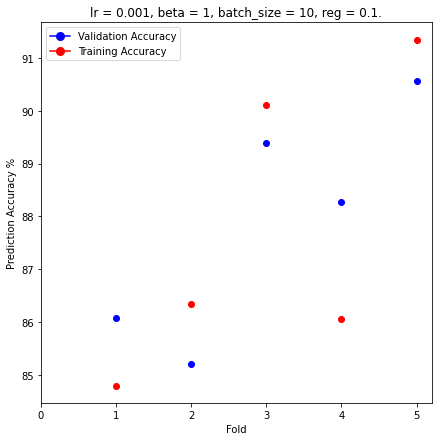


For fold 1 model has validation accuracy 84.96%% and has training accuracy 83.68%
For fold 2 model has validation accuracy 78.49%% and has training accuracy 80.28%
For fold 3 model has validation accuracy 86.03%% and has training accuracy 85.57%
For fold 4 model has validation accuracy 83.80%% and has training accuracy 84.04%
For fold 5 model has validation accuracy 81.94%% and has training accuracy 87.30%


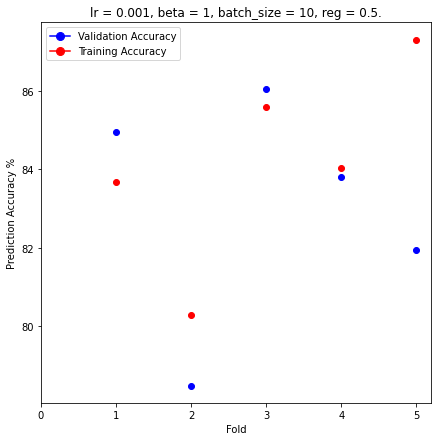


For fold 1 model has validation accuracy 90.53%% and has training accuracy 90.24%
For fold 2 model has validation accuracy 88.27%% and has training accuracy 90.24%
For fold 3 model has validation accuracy 92.74%% and has training accuracy 91.15%
For fold 4 model has validation accuracy 88.83%% and has training accuracy 89.13%
For fold 5 model has validation accuracy 90.00%% and has training accuracy 92.39%


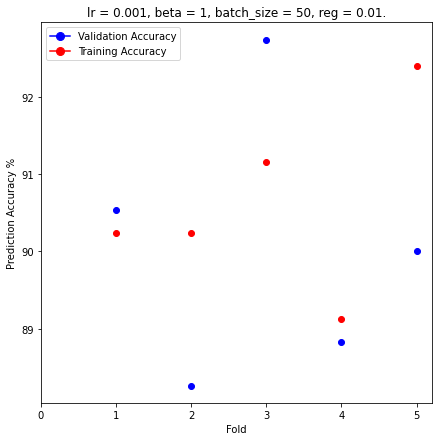


For fold 1 model has validation accuracy 91.92%% and has training accuracy 89.89%
For fold 2 model has validation accuracy 89.39%% and has training accuracy 91.29%
For fold 3 model has validation accuracy 89.94%% and has training accuracy 90.45%
For fold 4 model has validation accuracy 92.18%% and has training accuracy 91.71%
For fold 5 model has validation accuracy 88.33%% and has training accuracy 91.70%


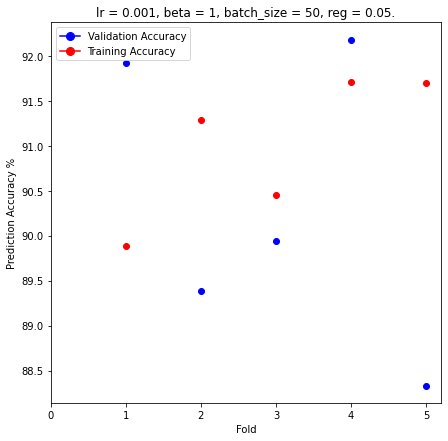


For fold 1 model has validation accuracy 91.09%% and has training accuracy 91.56%
For fold 2 model has validation accuracy 88.55%% and has training accuracy 89.69%
For fold 3 model has validation accuracy 91.06%% and has training accuracy 92.06%
For fold 4 model has validation accuracy 89.94%% and has training accuracy 91.64%
For fold 5 model has validation accuracy 90.56%% and has training accuracy 93.58%



For fold 1 model has validation accuracy 92.48%% and has training accuracy 91.07%
For fold 2 model has validation accuracy 90.22%% and has training accuracy 91.29%
For fold 3 model has validation accuracy 88.55%% and has training accuracy 88.99%
For fold 4 model has validation accuracy 92.74%% and has training accuracy 91.57%
For fold 5 model has validation accuracy 91.11%% and has training accuracy 92.53%



For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%



For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


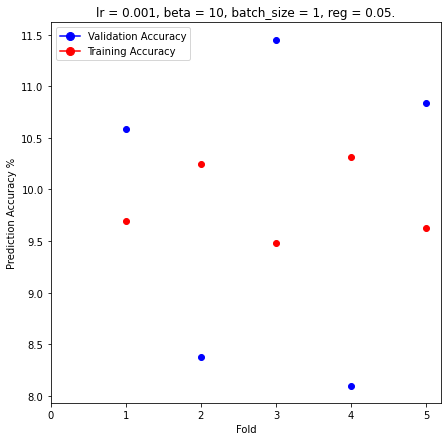


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%



For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


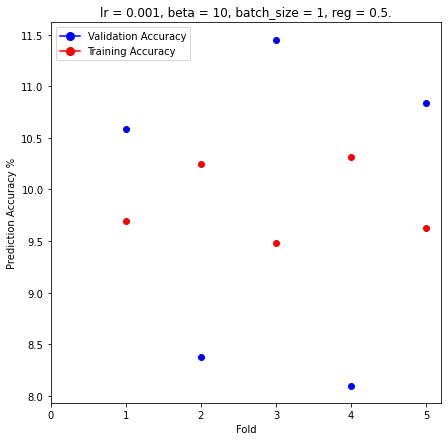


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


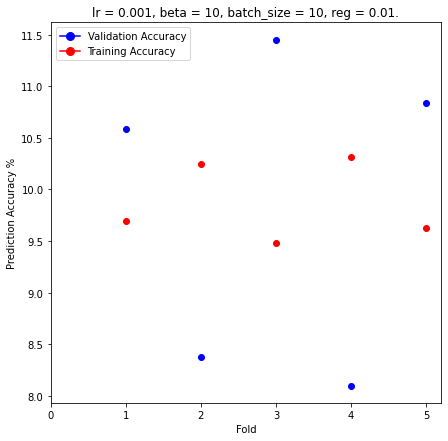


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


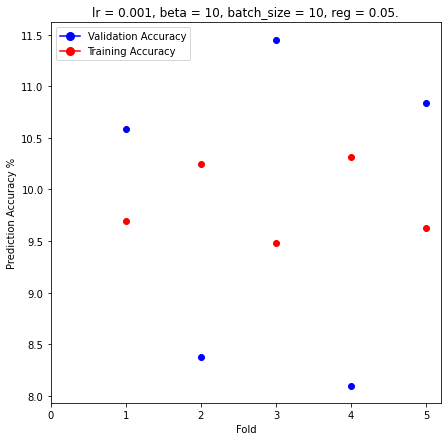


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


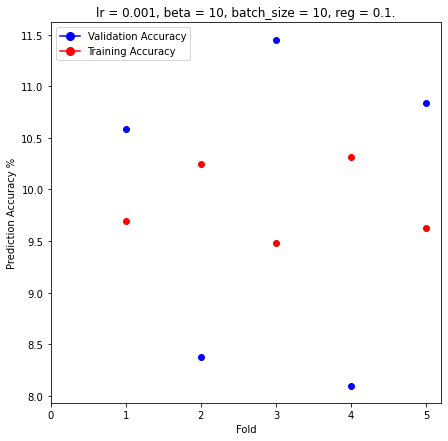


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


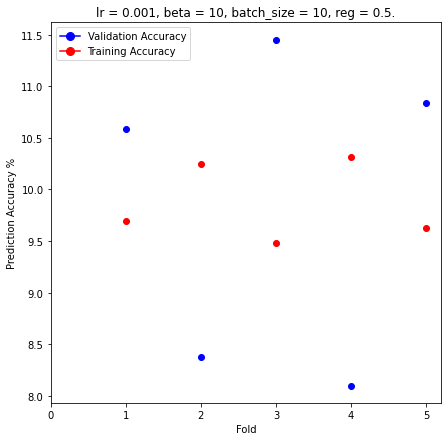


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


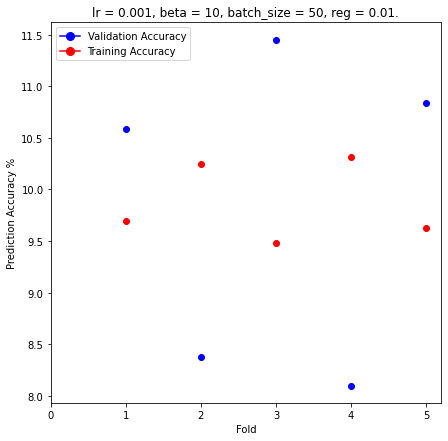


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


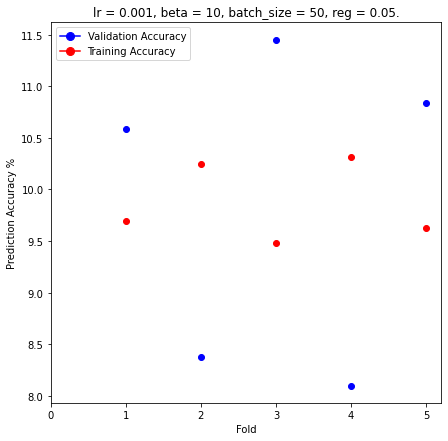


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


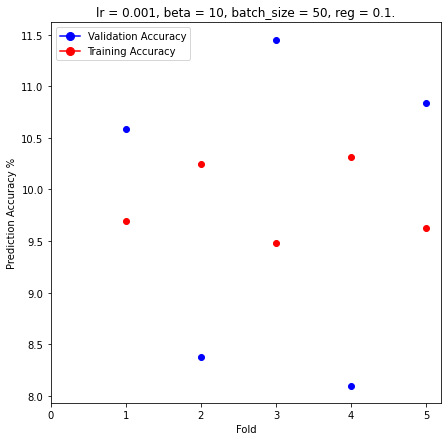


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


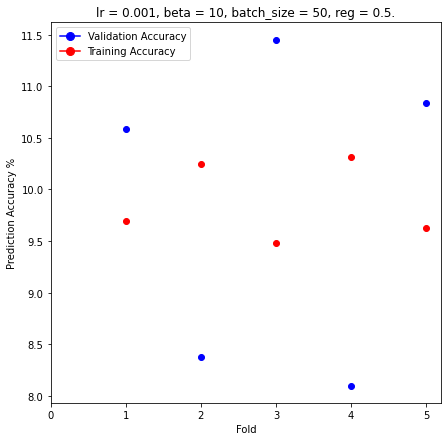


For fold 1 model has validation accuracy 71.31%% and has training accuracy 72.94%
For fold 2 model has validation accuracy 57.26%% and has training accuracy 57.84%
For fold 3 model has validation accuracy 57.54%% and has training accuracy 54.29%
For fold 4 model has validation accuracy 56.70%% and has training accuracy 61.05%
For fold 5 model has validation accuracy 23.89%% and has training accuracy 24.98%


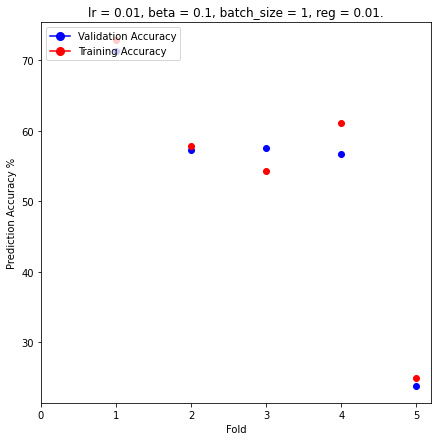


For fold 1 model has validation accuracy 26.46%% and has training accuracy 26.57%
For fold 2 model has validation accuracy 40.22%% and has training accuracy 45.57%
For fold 3 model has validation accuracy 40.78%% and has training accuracy 44.39%
For fold 4 model has validation accuracy 70.95%% and has training accuracy 70.59%
For fold 5 model has validation accuracy 44.72%% and has training accuracy 44.59%


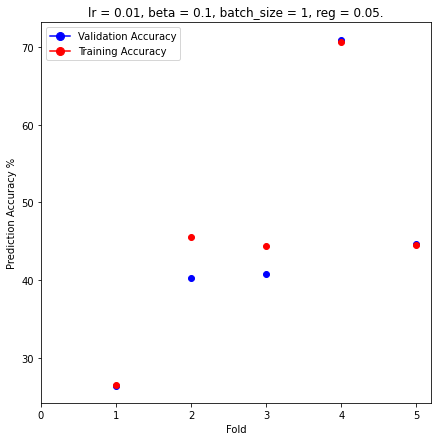


For fold 1 model has validation accuracy 47.35%% and has training accuracy 49.16%
For fold 2 model has validation accuracy 49.72%% and has training accuracy 42.23%
For fold 3 model has validation accuracy 41.90%% and has training accuracy 37.14%
For fold 4 model has validation accuracy 46.65%% and has training accuracy 50.38%
For fold 5 model has validation accuracy 26.11%% and has training accuracy 25.75%


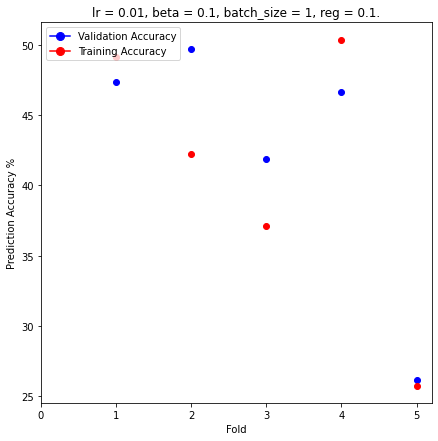


For fold 1 model has validation accuracy 37.60%% and has training accuracy 37.10%
For fold 2 model has validation accuracy 38.27%% and has training accuracy 41.46%
For fold 3 model has validation accuracy 17.04%% and has training accuracy 16.38%
For fold 4 model has validation accuracy 44.13%% and has training accuracy 42.23%
For fold 5 model has validation accuracy 30.00%% and has training accuracy 32.66%


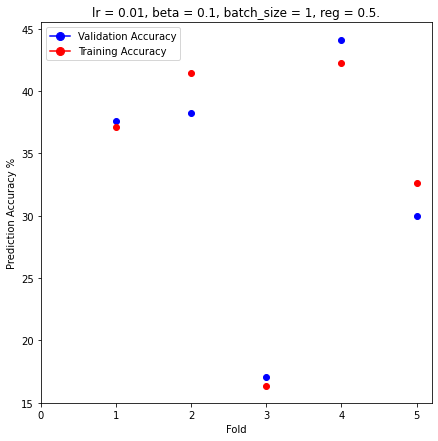


For fold 1 model has validation accuracy 84.68%% and has training accuracy 82.91%
For fold 2 model has validation accuracy 85.47%% and has training accuracy 88.29%
For fold 3 model has validation accuracy 87.15%% and has training accuracy 86.41%
For fold 4 model has validation accuracy 89.11%% and has training accuracy 89.41%
For fold 5 model has validation accuracy 90.28%% and has training accuracy 93.72%


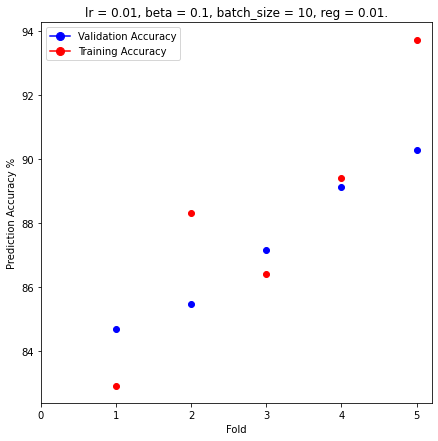


For fold 1 model has validation accuracy 86.63%% and has training accuracy 84.94%
For fold 2 model has validation accuracy 89.66%% and has training accuracy 92.54%
For fold 3 model has validation accuracy 87.43%% and has training accuracy 86.97%
For fold 4 model has validation accuracy 89.11%% and has training accuracy 89.90%
For fold 5 model has validation accuracy 89.72%% and has training accuracy 93.37%


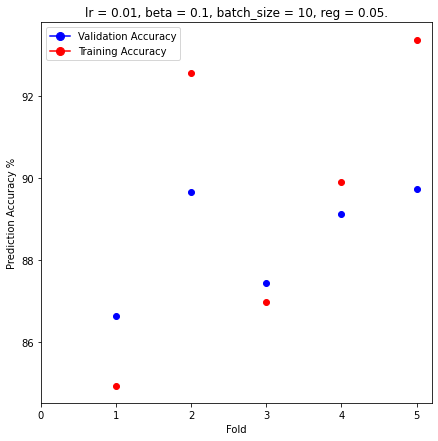


For fold 1 model has validation accuracy 91.36%% and has training accuracy 90.86%
For fold 2 model has validation accuracy 89.39%% and has training accuracy 92.06%
For fold 3 model has validation accuracy 92.74%% and has training accuracy 93.59%
For fold 4 model has validation accuracy 91.06%% and has training accuracy 89.83%
For fold 5 model has validation accuracy 80.28%% and has training accuracy 83.39%


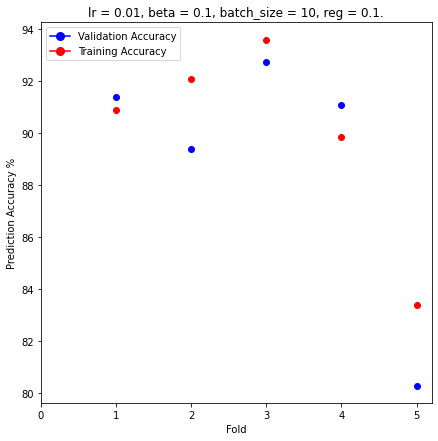


For fold 1 model has validation accuracy 88.30%% and has training accuracy 86.68%
For fold 2 model has validation accuracy 79.89%% and has training accuracy 83.14%
For fold 3 model has validation accuracy 88.27%% and has training accuracy 90.38%
For fold 4 model has validation accuracy 86.87%% and has training accuracy 85.23%
For fold 5 model has validation accuracy 87.78%% and has training accuracy 91.56%



For fold 1 model has validation accuracy 92.20%% and has training accuracy 92.54%
For fold 2 model has validation accuracy 87.71%% and has training accuracy 90.52%
For fold 3 model has validation accuracy 90.50%% and has training accuracy 92.54%
For fold 4 model has validation accuracy 90.78%% and has training accuracy 89.41%
For fold 5 model has validation accuracy 91.67%% and has training accuracy 93.65%


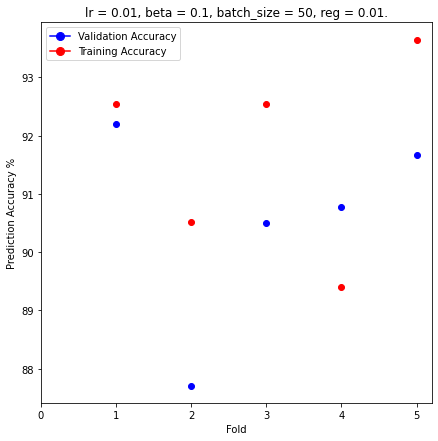


For fold 1 model has validation accuracy 93.87%% and has training accuracy 93.51%
For fold 2 model has validation accuracy 90.50%% and has training accuracy 90.59%
For fold 3 model has validation accuracy 93.85%% and has training accuracy 93.10%
For fold 4 model has validation accuracy 87.15%% and has training accuracy 84.46%
For fold 5 model has validation accuracy 90.00%% and has training accuracy 92.74%


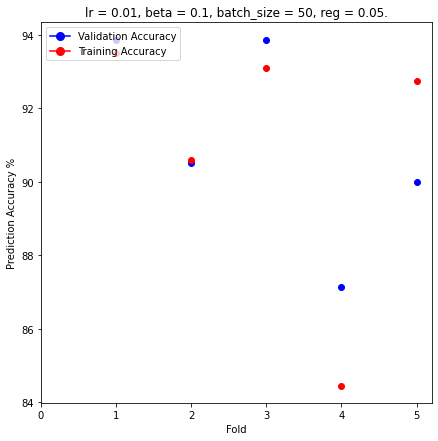


For fold 1 model has validation accuracy 91.92%% and has training accuracy 89.61%
For fold 2 model has validation accuracy 79.33%% and has training accuracy 85.85%
For fold 3 model has validation accuracy 91.62%% and has training accuracy 92.68%
For fold 4 model has validation accuracy 84.92%% and has training accuracy 86.55%
For fold 5 model has validation accuracy 85.83%% and has training accuracy 85.35%


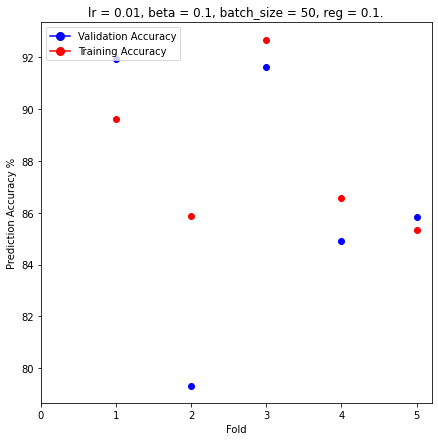


For fold 1 model has validation accuracy 86.91%% and has training accuracy 84.73%
For fold 2 model has validation accuracy 91.34%% and has training accuracy 92.13%
For fold 3 model has validation accuracy 93.02%% and has training accuracy 94.01%
For fold 4 model has validation accuracy 82.12%% and has training accuracy 81.11%
For fold 5 model has validation accuracy 73.89%% and has training accuracy 78.37%


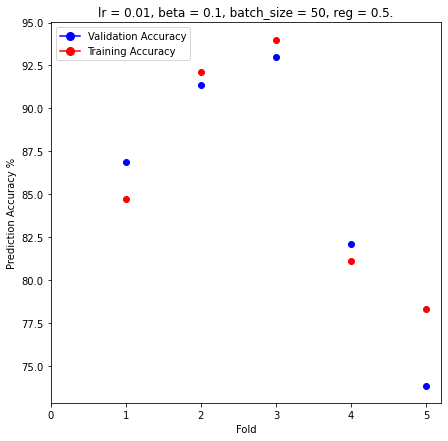


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 20.11%% and has training accuracy 17.14%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


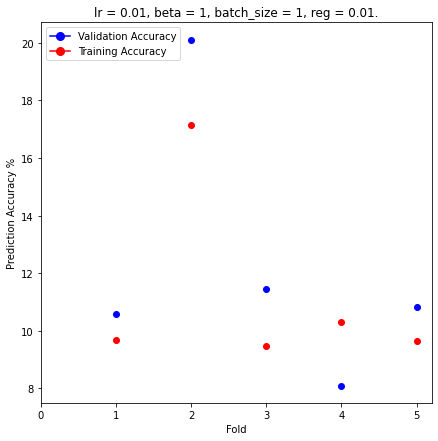


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 36.03%% and has training accuracy 36.52%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


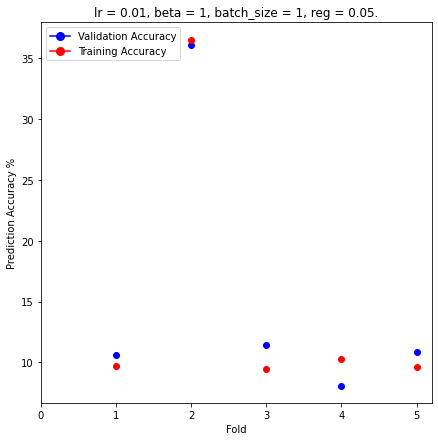


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


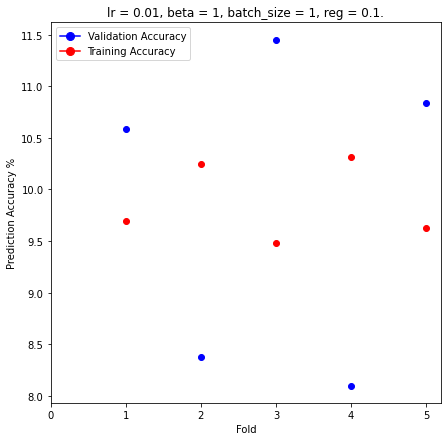


For fold 1 model has validation accuracy 27.30%% and has training accuracy 27.20%
For fold 2 model has validation accuracy 28.49%% and has training accuracy 28.64%
For fold 3 model has validation accuracy 25.98%% and has training accuracy 27.74%
For fold 4 model has validation accuracy 23.74%% and has training accuracy 24.11%
For fold 5 model has validation accuracy 18.89%% and has training accuracy 18.91%


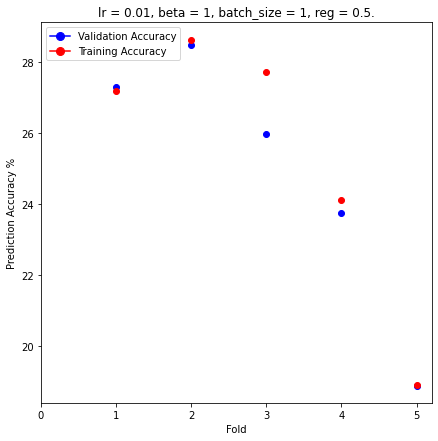


For fold 1 model has validation accuracy 84.12%% and has training accuracy 82.15%
For fold 2 model has validation accuracy 68.72%% and has training accuracy 71.71%
For fold 3 model has validation accuracy 81.56%% and has training accuracy 81.60%
For fold 4 model has validation accuracy 80.17%% and has training accuracy 83.34%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


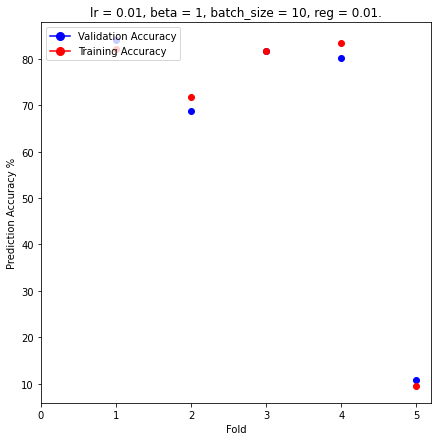


For fold 1 model has validation accuracy 73.54%% and has training accuracy 70.36%
For fold 2 model has validation accuracy 75.42%% and has training accuracy 78.61%
For fold 3 model has validation accuracy 72.07%% and has training accuracy 71.78%
For fold 4 model has validation accuracy 76.26%% and has training accuracy 78.68%
For fold 5 model has validation accuracy 70.83%% and has training accuracy 74.32%


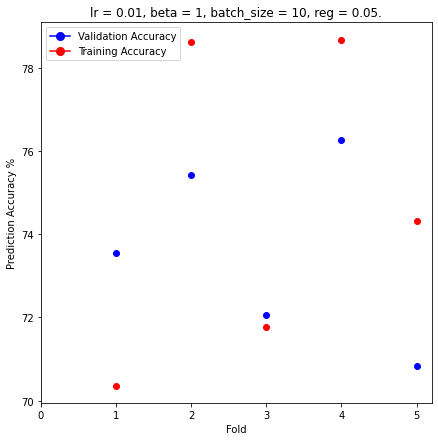


For fold 1 model has validation accuracy 84.68%% and has training accuracy 84.59%
For fold 2 model has validation accuracy 66.76%% and has training accuracy 69.20%
For fold 3 model has validation accuracy 50.56%% and has training accuracy 53.38%
For fold 4 model has validation accuracy 50.00%% and has training accuracy 47.53%
For fold 5 model has validation accuracy 66.11%% and has training accuracy 66.57%


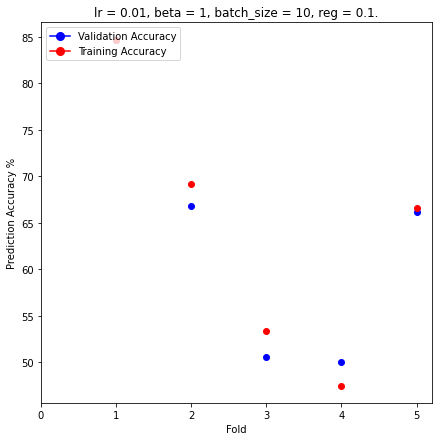


For fold 1 model has validation accuracy 30.08%% and has training accuracy 30.61%
For fold 2 model has validation accuracy 15.08%% and has training accuracy 11.36%
For fold 3 model has validation accuracy 32.40%% and has training accuracy 31.43%
For fold 4 model has validation accuracy 46.37%% and has training accuracy 41.81%
For fold 5 model has validation accuracy 38.61%% and has training accuracy 38.24%


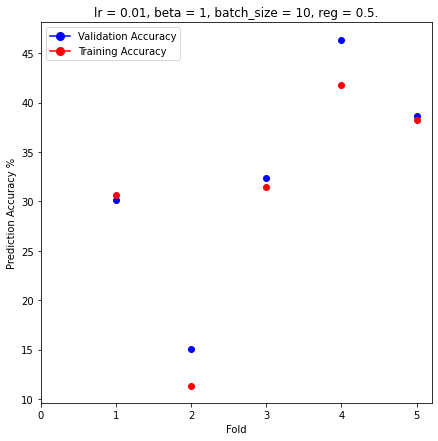


For fold 1 model has validation accuracy 89.42%% and has training accuracy 89.05%
For fold 2 model has validation accuracy 87.43%% and has training accuracy 90.45%
For fold 3 model has validation accuracy 82.68%% and has training accuracy 85.23%
For fold 4 model has validation accuracy 88.27%% and has training accuracy 87.53%
For fold 5 model has validation accuracy 89.72%% and has training accuracy 91.70%


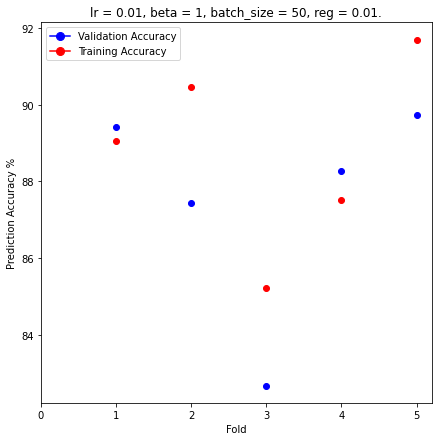


For fold 1 model has validation accuracy 81.62%% and has training accuracy 81.87%
For fold 2 model has validation accuracy 89.39%% and has training accuracy 90.73%
For fold 3 model has validation accuracy 85.75%% and has training accuracy 86.06%
For fold 4 model has validation accuracy 88.55%% and has training accuracy 87.80%
For fold 5 model has validation accuracy 91.11%% and has training accuracy 93.16%


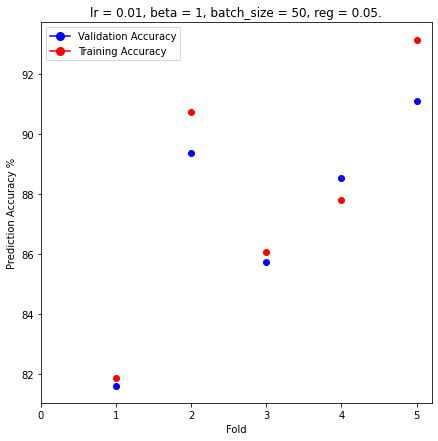


For fold 1 model has validation accuracy 88.02%% and has training accuracy 88.98%
For fold 2 model has validation accuracy 77.93%% and has training accuracy 81.60%
For fold 3 model has validation accuracy 87.43%% and has training accuracy 88.50%
For fold 4 model has validation accuracy 90.22%% and has training accuracy 90.17%
For fold 5 model has validation accuracy 82.22%% and has training accuracy 86.88%


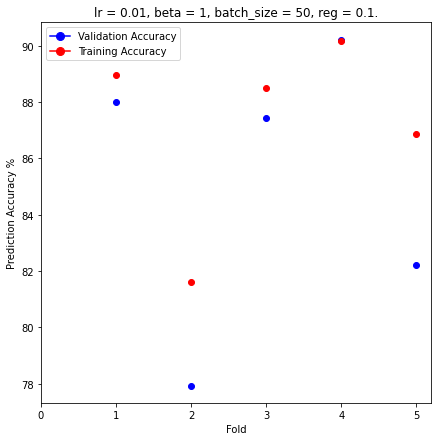


For fold 1 model has validation accuracy 68.25%% and has training accuracy 70.92%
For fold 2 model has validation accuracy 79.89%% and has training accuracy 83.62%
For fold 3 model has validation accuracy 86.31%% and has training accuracy 87.87%
For fold 4 model has validation accuracy 84.64%% and has training accuracy 83.28%
For fold 5 model has validation accuracy 74.44%% and has training accuracy 76.90%


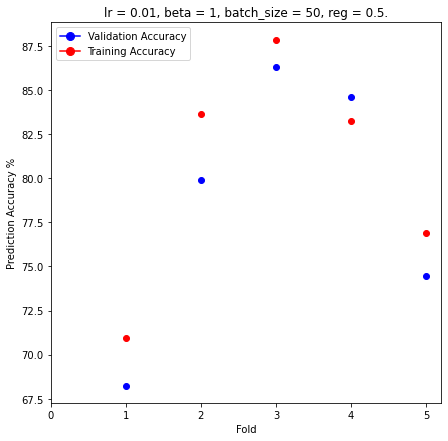


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


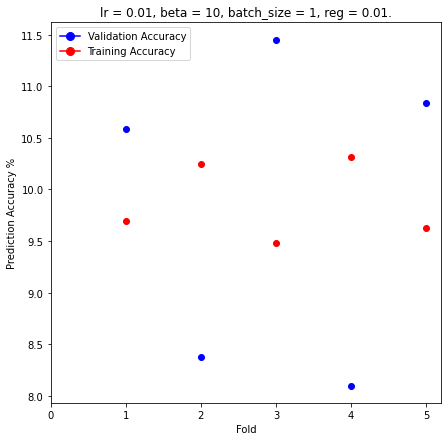


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


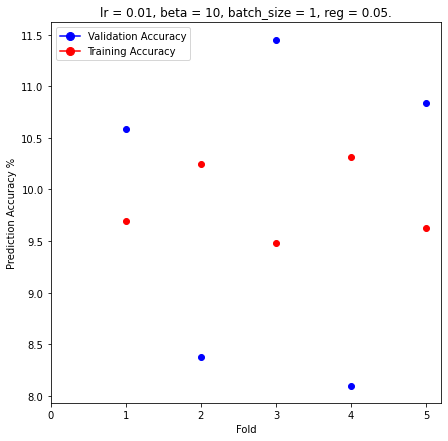


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


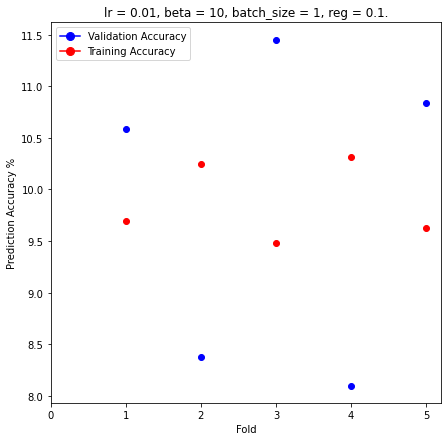


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


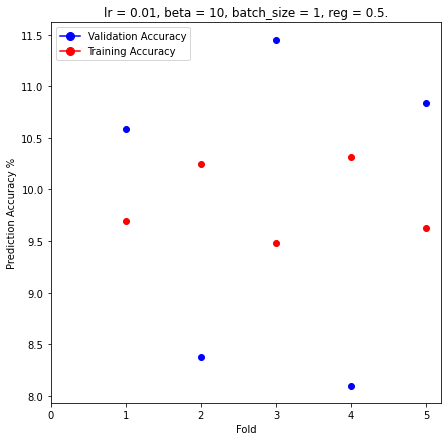


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


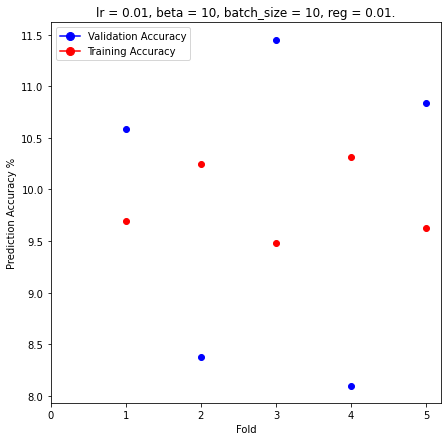


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


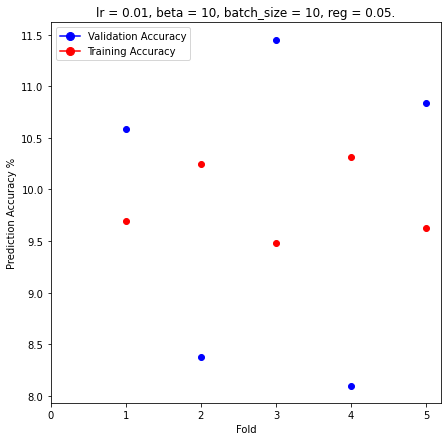


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%



For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


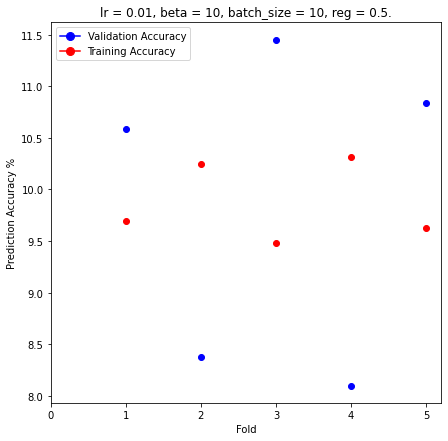


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


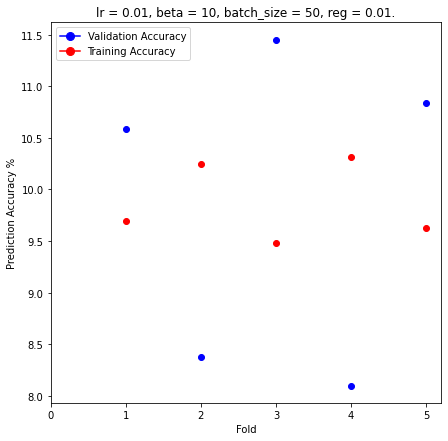


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


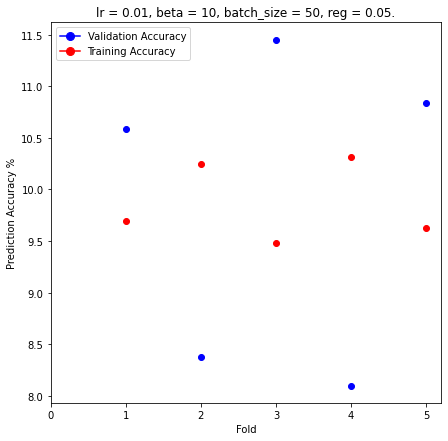


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


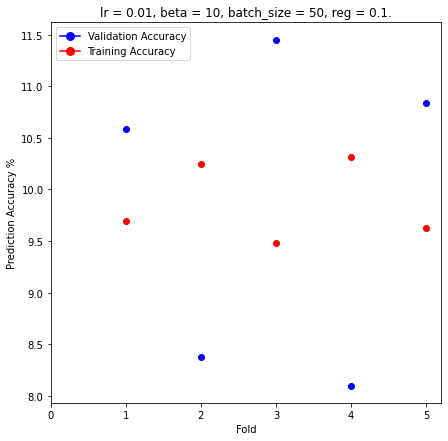


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


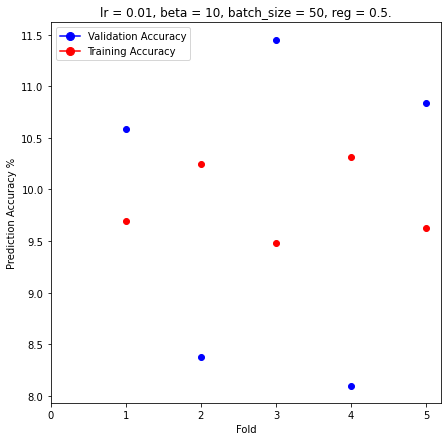


For fold 1 model has validation accuracy 22.56%% and has training accuracy 23.78%
For fold 2 model has validation accuracy 38.27%% and has training accuracy 42.09%
For fold 3 model has validation accuracy 21.51%% and has training accuracy 25.51%
For fold 4 model has validation accuracy 41.90%% and has training accuracy 41.53%
For fold 5 model has validation accuracy 49.17%% and has training accuracy 50.45%



For fold 1 model has validation accuracy 33.15%% and has training accuracy 32.57%
For fold 2 model has validation accuracy 52.51%% and has training accuracy 58.75%
For fold 3 model has validation accuracy 26.54%% and has training accuracy 28.50%
For fold 4 model has validation accuracy 39.94%% and has training accuracy 38.05%
For fold 5 model has validation accuracy 39.72%% and has training accuracy 41.31%



For fold 1 model has validation accuracy 40.11%% and has training accuracy 40.73%
For fold 2 model has validation accuracy 25.42%% and has training accuracy 18.75%
For fold 3 model has validation accuracy 34.64%% and has training accuracy 35.19%
For fold 4 model has validation accuracy 12.29%% and has training accuracy 13.59%
For fold 5 model has validation accuracy 35.28%% and has training accuracy 34.61%



For fold 1 model has validation accuracy 9.47%% and has training accuracy 9.76%
For fold 2 model has validation accuracy 8.66%% and has training accuracy 12.47%
For fold 3 model has validation accuracy 12.57%% and has training accuracy 14.29%
For fold 4 model has validation accuracy 7.26%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 24.72%% and has training accuracy 27.84%


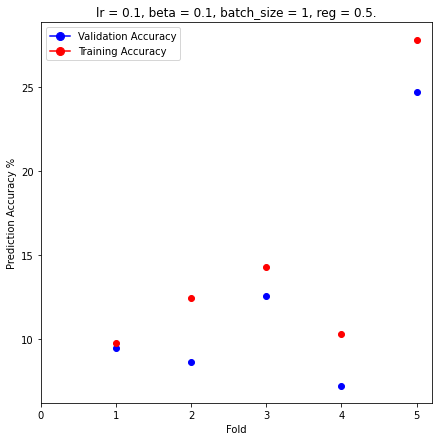


For fold 1 model has validation accuracy 67.97%% and has training accuracy 68.27%
For fold 2 model has validation accuracy 79.33%% and has training accuracy 81.39%
For fold 3 model has validation accuracy 65.36%% and has training accuracy 66.34%
For fold 4 model has validation accuracy 86.87%% and has training accuracy 84.81%
For fold 5 model has validation accuracy 72.50%% and has training accuracy 73.13%


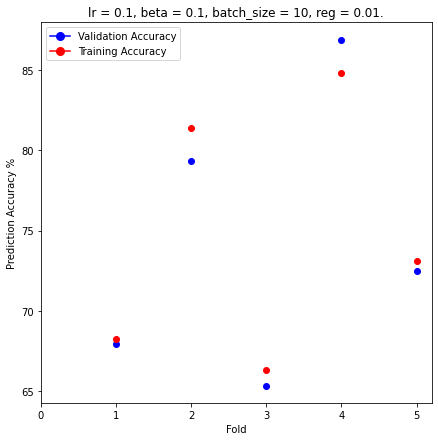


For fold 1 model has validation accuracy 70.75%% and has training accuracy 70.78%
For fold 2 model has validation accuracy 79.05%% and has training accuracy 80.98%
For fold 3 model has validation accuracy 57.54%% and has training accuracy 59.37%
For fold 4 model has validation accuracy 72.63%% and has training accuracy 71.15%
For fold 5 model has validation accuracy 83.33%% and has training accuracy 85.00%


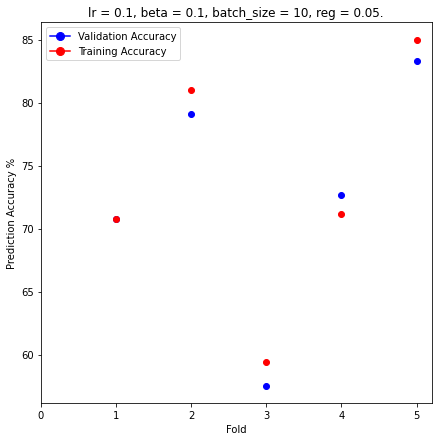


For fold 1 model has validation accuracy 75.21%% and has training accuracy 73.57%
For fold 2 model has validation accuracy 61.45%% and has training accuracy 59.23%
For fold 3 model has validation accuracy 81.28%% and has training accuracy 80.70%
For fold 4 model has validation accuracy 71.23%% and has training accuracy 71.78%
For fold 5 model has validation accuracy 77.50%% and has training accuracy 82.00%


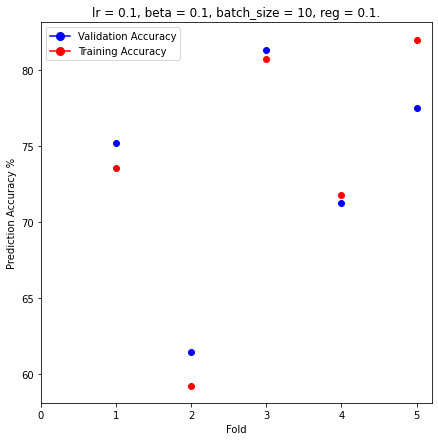


For fold 1 model has validation accuracy 8.64%% and has training accuracy 10.39%
For fold 2 model has validation accuracy 29.33%% and has training accuracy 31.85%
For fold 3 model has validation accuracy 63.97%% and has training accuracy 64.25%
For fold 4 model has validation accuracy 46.65%% and has training accuracy 44.74%
For fold 5 model has validation accuracy 46.39%% and has training accuracy 47.80%


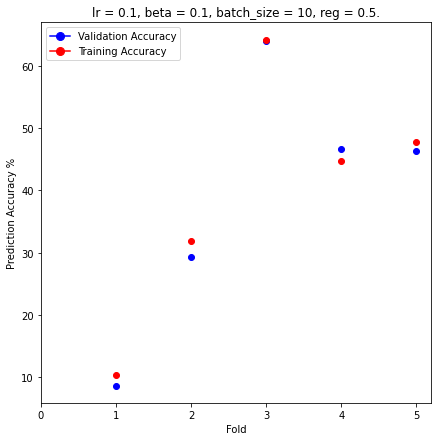


For fold 1 model has validation accuracy 88.02%% and has training accuracy 86.75%
For fold 2 model has validation accuracy 90.22%% and has training accuracy 91.08%
For fold 3 model has validation accuracy 84.08%% and has training accuracy 86.83%
For fold 4 model has validation accuracy 80.17%% and has training accuracy 83.69%
For fold 5 model has validation accuracy 89.72%% and has training accuracy 91.00%


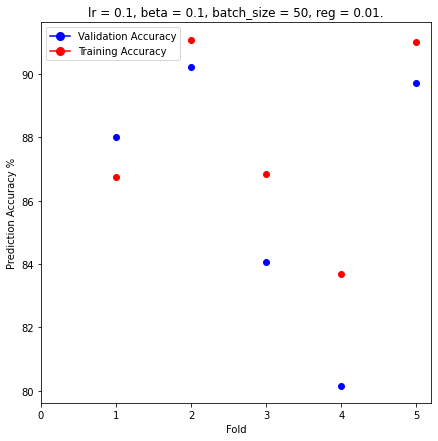


For fold 1 model has validation accuracy 76.32%% and has training accuracy 74.55%
For fold 2 model has validation accuracy 67.04%% and has training accuracy 65.57%
For fold 3 model has validation accuracy 89.94%% and has training accuracy 88.57%
For fold 4 model has validation accuracy 75.42%% and has training accuracy 76.45%
For fold 5 model has validation accuracy 81.39%% and has training accuracy 83.60%



For fold 1 model has validation accuracy 70.47%% and has training accuracy 70.64%
For fold 2 model has validation accuracy 77.09%% and has training accuracy 77.91%
For fold 3 model has validation accuracy 84.92%% and has training accuracy 85.51%
For fold 4 model has validation accuracy 70.39%% and has training accuracy 70.17%
For fold 5 model has validation accuracy 77.78%% and has training accuracy 80.46%



For fold 1 model has validation accuracy 65.18%% and has training accuracy 65.90%
For fold 2 model has validation accuracy 37.15%% and has training accuracy 46.06%
For fold 3 model has validation accuracy 78.49%% and has training accuracy 79.16%
For fold 4 model has validation accuracy 80.17%% and has training accuracy 77.77%
For fold 5 model has validation accuracy 29.72%% and has training accuracy 32.45%


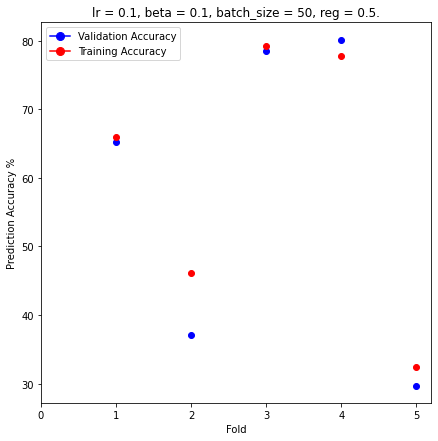


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


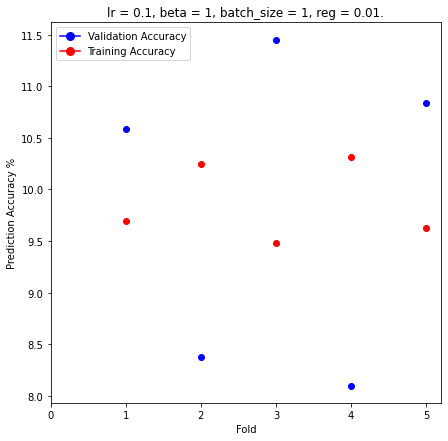


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


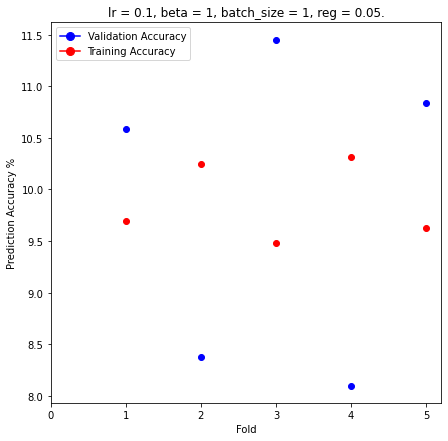


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


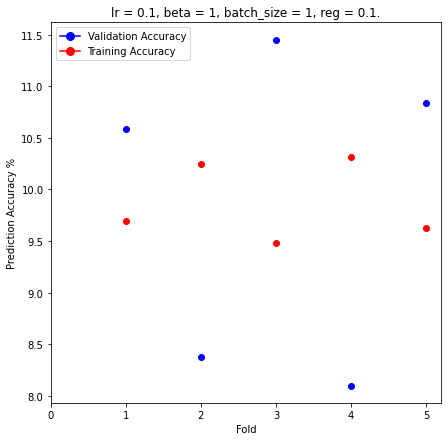


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%



For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


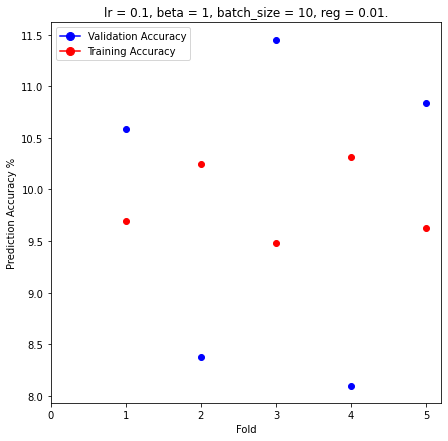


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%



For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


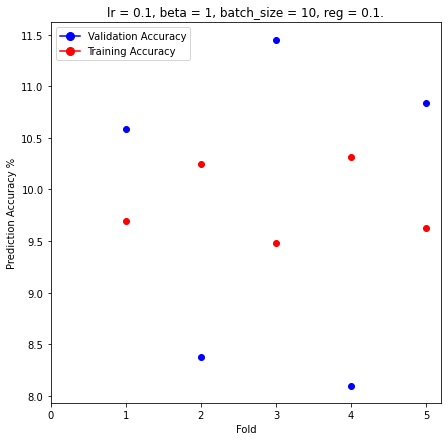


For fold 1 model has validation accuracy 20.61%% and has training accuracy 20.15%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 39.66%% and has training accuracy 35.68%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 18.61%% and has training accuracy 18.00%


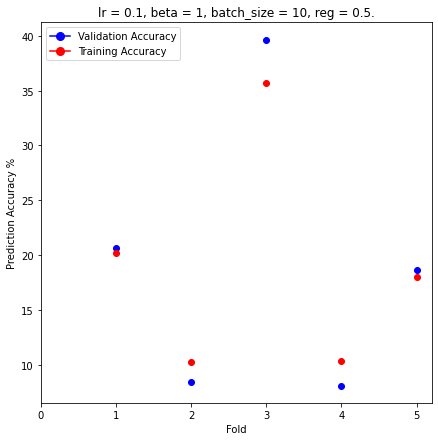


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%



For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


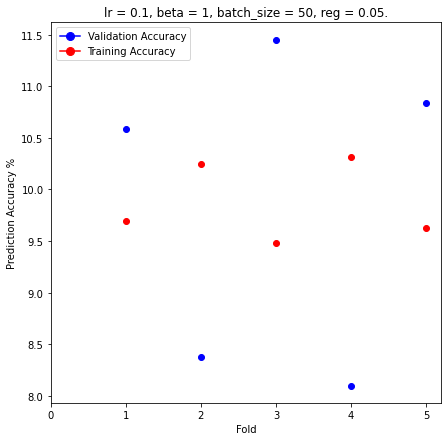


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


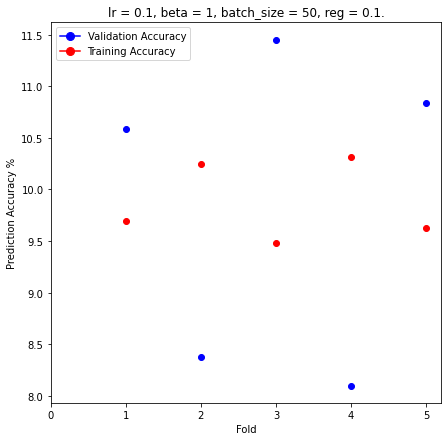


For fold 1 model has validation accuracy 11.14%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 33.80%% and has training accuracy 37.14%
For fold 3 model has validation accuracy 23.46%% and has training accuracy 23.76%
For fold 4 model has validation accuracy 23.18%% and has training accuracy 25.64%
For fold 5 model has validation accuracy 30.28%% and has training accuracy 28.54%



For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


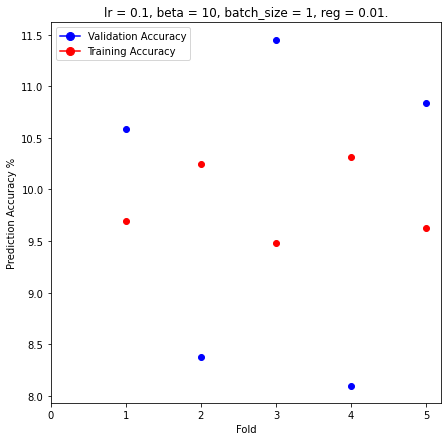


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%



For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


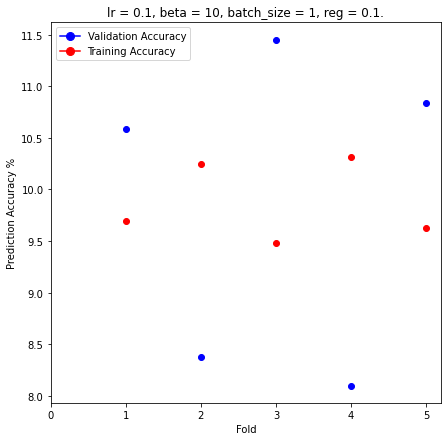


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%



For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


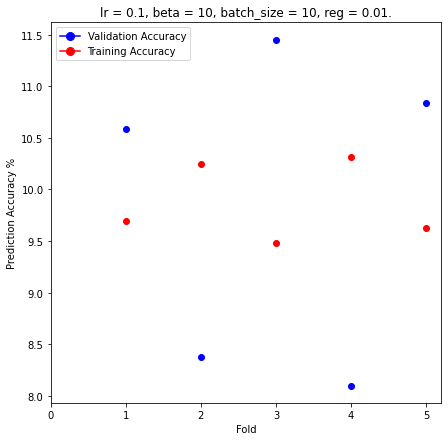


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


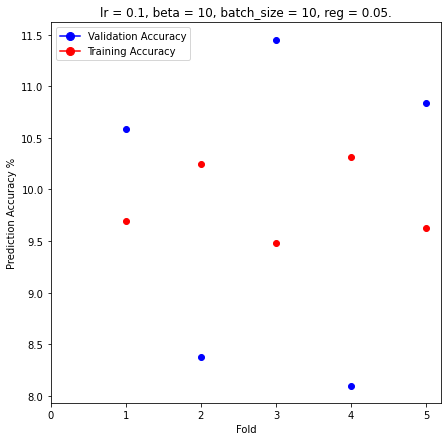


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


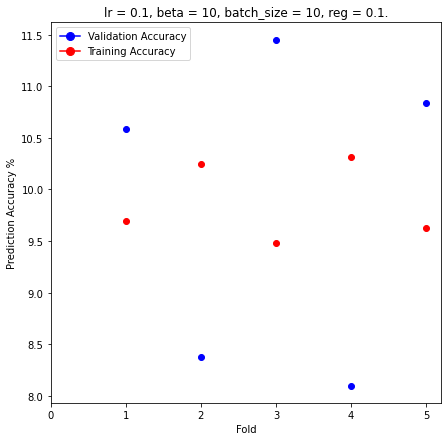


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


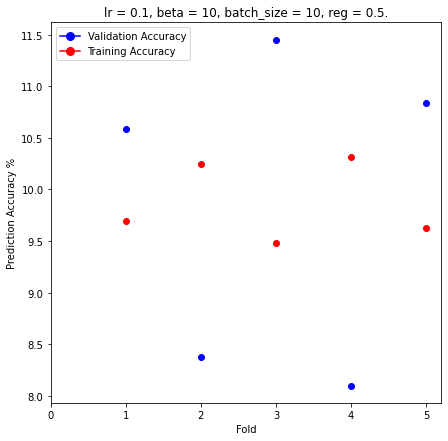


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


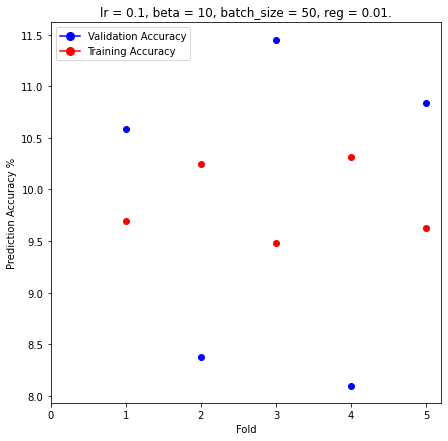


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%


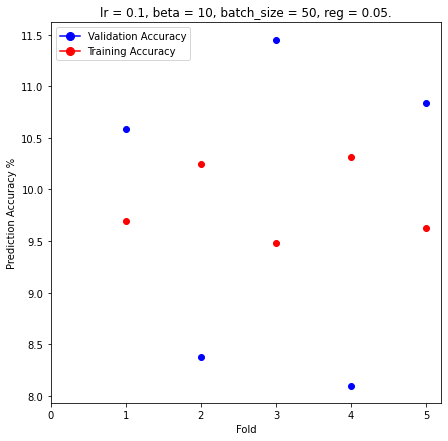


For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%



For fold 1 model has validation accuracy 10.58%% and has training accuracy 9.69%
For fold 2 model has validation accuracy 8.38%% and has training accuracy 10.24%
For fold 3 model has validation accuracy 11.45%% and has training accuracy 9.48%
For fold 4 model has validation accuracy 8.10%% and has training accuracy 10.31%
For fold 5 model has validation accuracy 10.83%% and has training accuracy 9.63%



Highest mean validation accuracy was 0.9107604923670657. Params were LR: 0.01, Beta: 0.1, BatchSize: 50, Reg: 0.05


In [ ]:
#Hyperparameter tuning for digits dataset
learning_rate = [0.0001, 0.001, 0.01, 0.1]
beta = [0.1, 1, 10]
batch_size = [1, 10, 50]
reg = [0.01, 0.05, 0.1, 0.5]

maxValidationAccuracy = 0
params = (0,0,0,0)

for lr in learning_rate:
  for b in beta:
    for batch in batch_size:
      for r in reg:
        accuracyValid, accuracyTrain = modelExecution(digitFolds, lr, b, batch, r)
        plt.figure(figsize=(7,7))
        for i in range(len(accuracyValid)):
          print("For fold "+str(i+1)+" model has validation accuracy {:.2%}".format(accuracyValid[i])+"% "+"and has training accuracy {:.2%}".format(accuracyTrain[i]))
          
          #Create the grapghs as we loop through the different params
          plt.scatter(i+1, accuracyValid[i] * 100, c = "Blue", label = "Validation Accuracy")
          plt.scatter(i+1, accuracyTrain[i] * 100, c = "Red", label = "Training Accuracy")
        
        #Keep track of params with highest mean validation accuracy
        if maxValidationAccuracy < (sum(accuracyValid)/5):
          maxValidationAccuracy = sum(accuracyValid)/5
          params = (lr, b, batch, r)

        #Print the scatter plot
        plt.xlabel("Fold")
        plt.xticks([0,1,2,3,4,5])
        plt.ylabel("Prediction Accuracy %")
        plt.title("lr = "+str(lr)+", beta = "+str(b)+", batch_size = "+str(batch)+", reg = "+str(r)+".")
        plt.legend(handles = legend_elements, loc = 2)
        plt.show()

        print()

bestLR_digits, bestB_digits, bestBatch_digits, bestR_digits = params
print("Highest mean validation accuracy was "+str(maxValidationAccuracy)+". Params were LR: "+str(bestLR_digits)+", Beta: "+str(bestB_digits)+", BatchSize: "+str(bestBatch_digits)+", Reg: "+str(bestR_digits))

###Hyperparameter tuning for Iris 

For fold 1 model has validation accuracy 26.67%% and has training accuracy 35.34%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 36.75%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


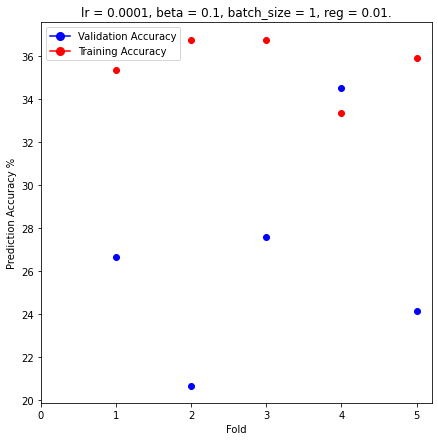


For fold 1 model has validation accuracy 26.67%% and has training accuracy 35.34%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 51.72%% and has training accuracy 29.06%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 26.67%% and has training accuracy 35.34%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 51.72%% and has training accuracy 29.06%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 32.48%



For fold 1 model has validation accuracy 26.67%% and has training accuracy 35.34%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 37.61%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


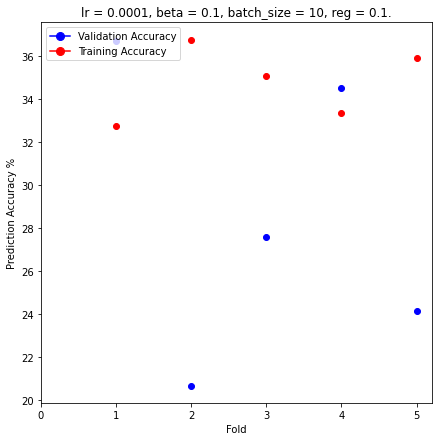


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 34.48%% and has training accuracy 41.88%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


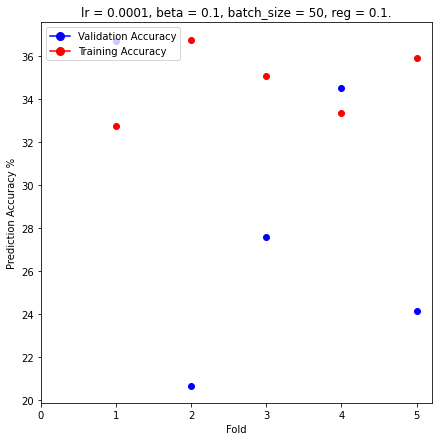


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


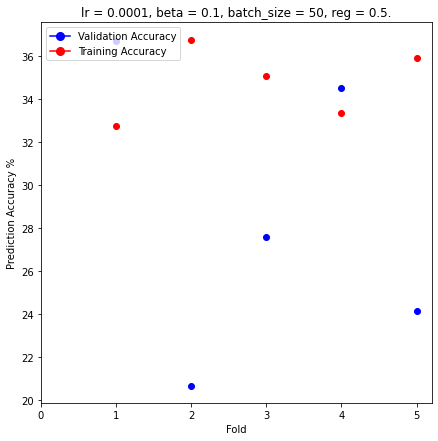


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 32.48%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 41.38%% and has training accuracy 53.85%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 62.07%% and has training accuracy 67.52%


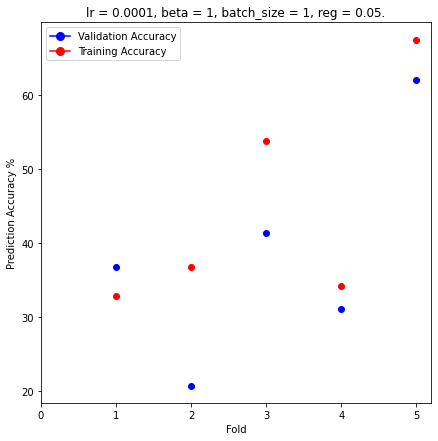


For fold 1 model has validation accuracy 43.33%% and has training accuracy 36.21%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 55.17%% and has training accuracy 64.96%


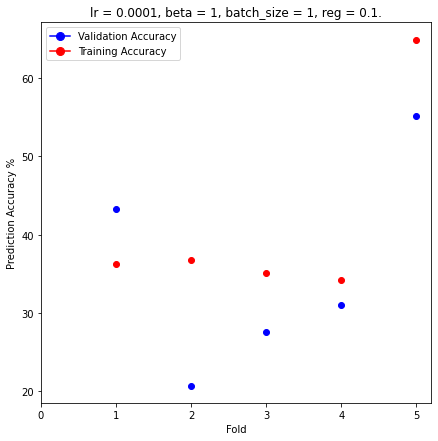


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 51.72%% and has training accuracy 29.06%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


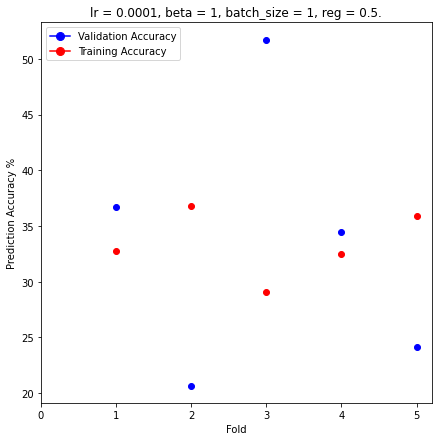


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 51.72%% and has training accuracy 52.99%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


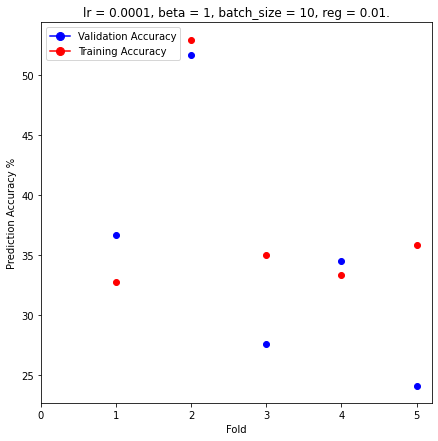


For fold 1 model has validation accuracy 26.67%% and has training accuracy 35.34%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


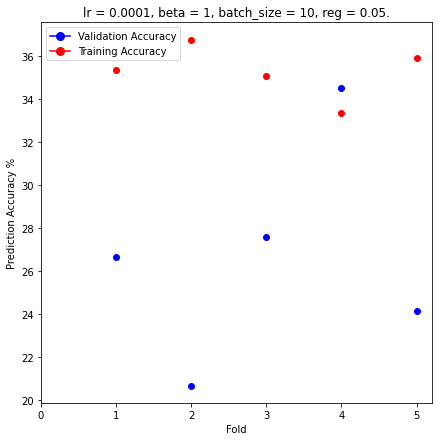


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


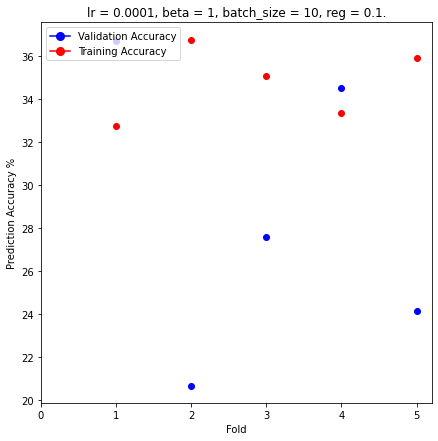


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


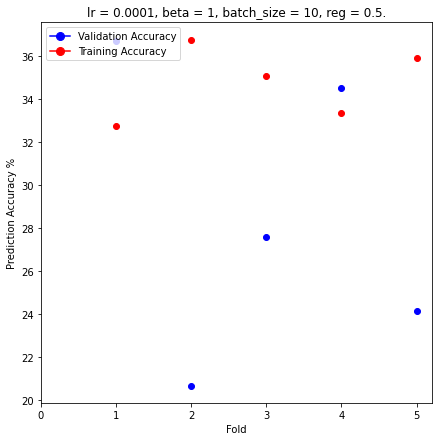


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


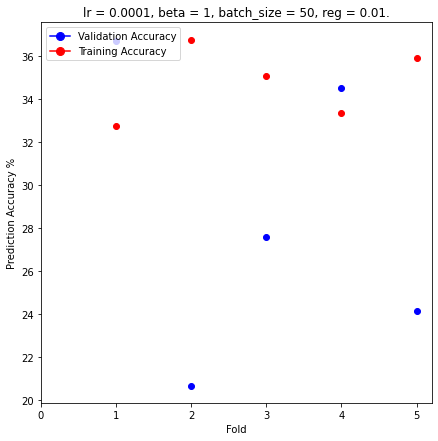


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


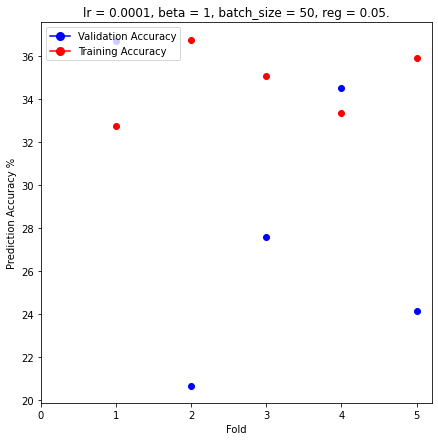


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


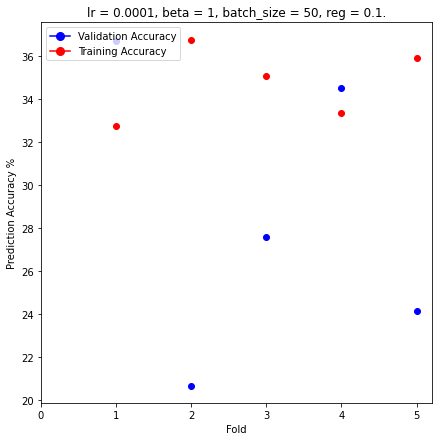


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 24.14%% and has training accuracy 40.17%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


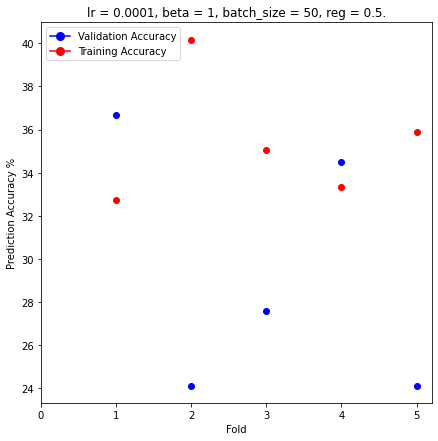


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


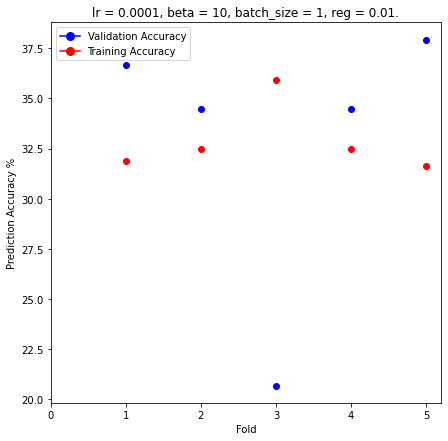


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


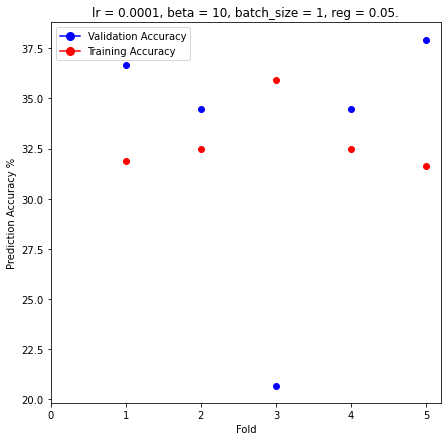


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


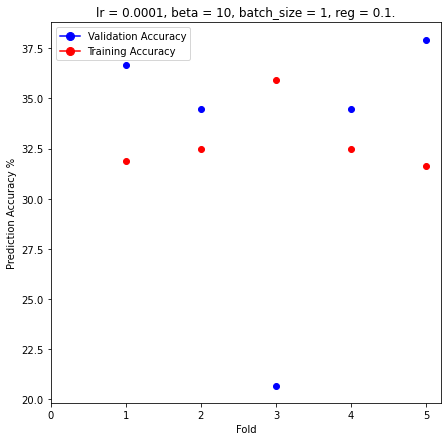


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


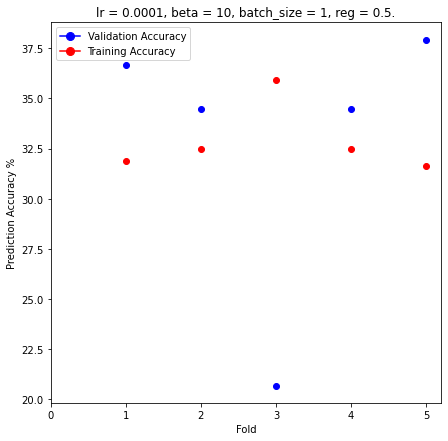


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


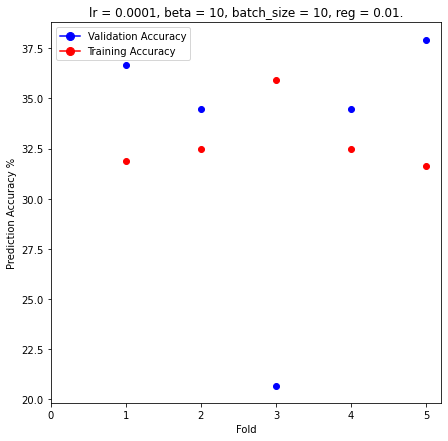


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


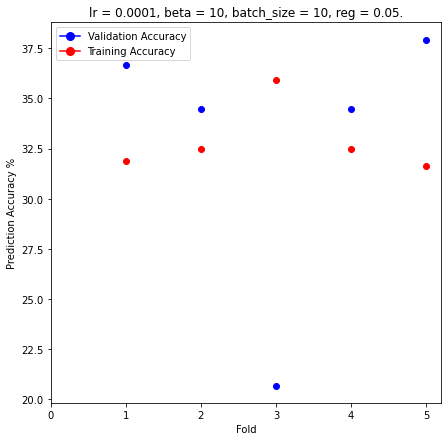


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


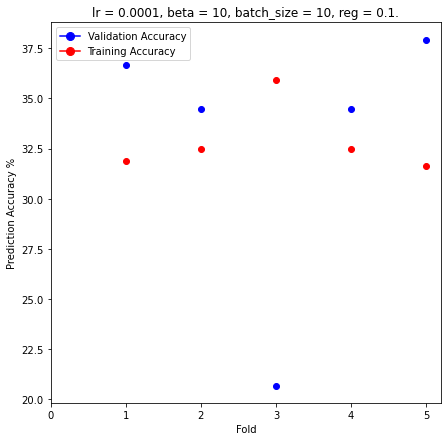


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


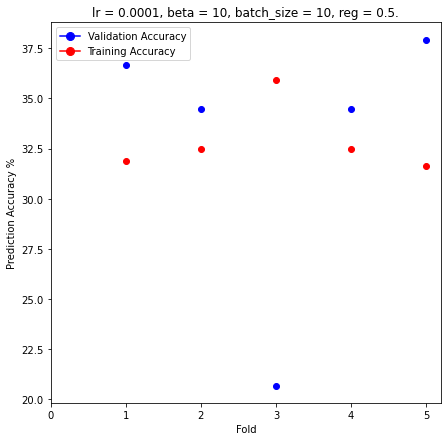


For fold 1 model has validation accuracy 26.67%% and has training accuracy 35.34%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


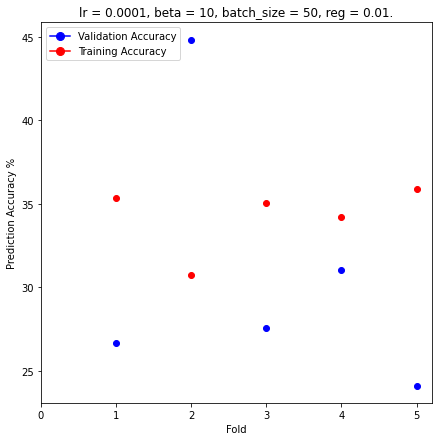


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


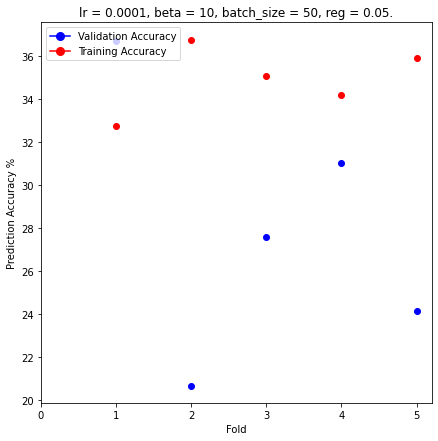


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 60.68%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


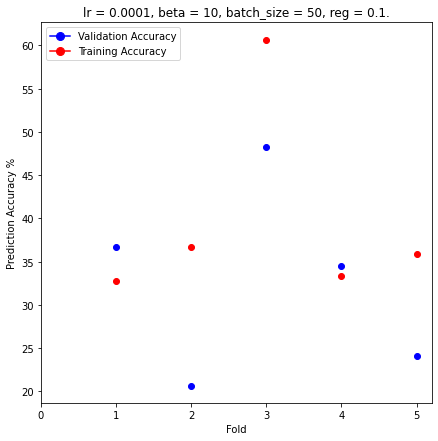


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 36.75%
For fold 4 model has validation accuracy 68.97%% and has training accuracy 65.81%
For fold 5 model has validation accuracy 51.72%% and has training accuracy 62.39%


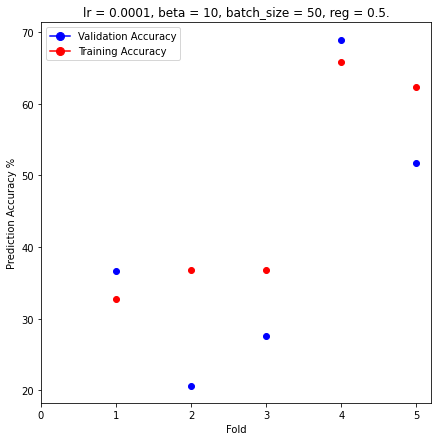


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 37.93%% and has training accuracy 47.86%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 26.67%% and has training accuracy 35.34%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


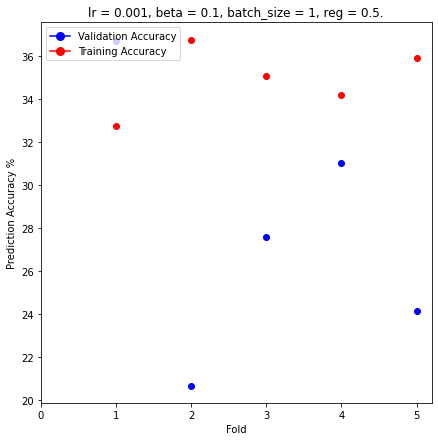


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


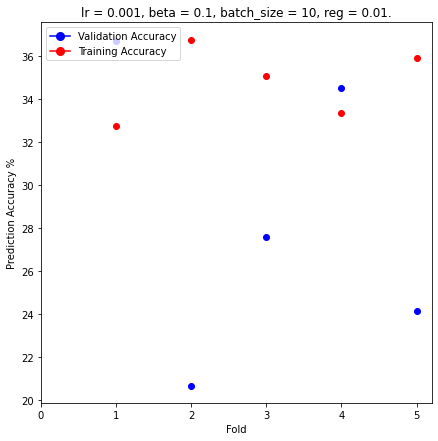


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 37.61%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


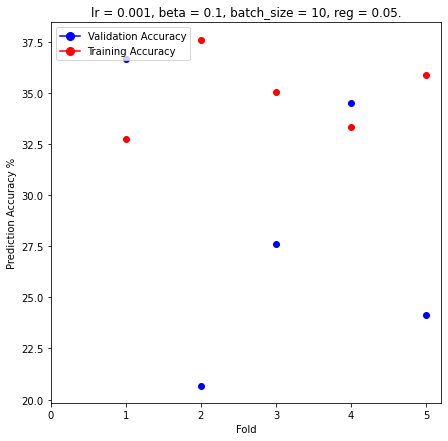


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


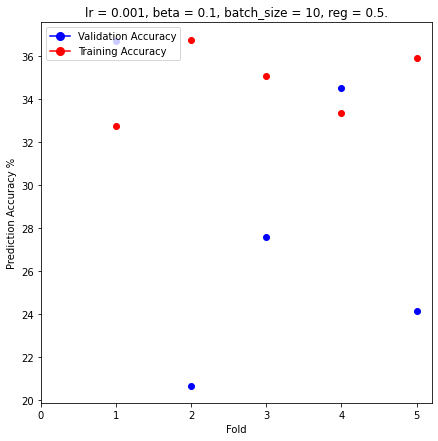


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 63.33%% and has training accuracy 64.66%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


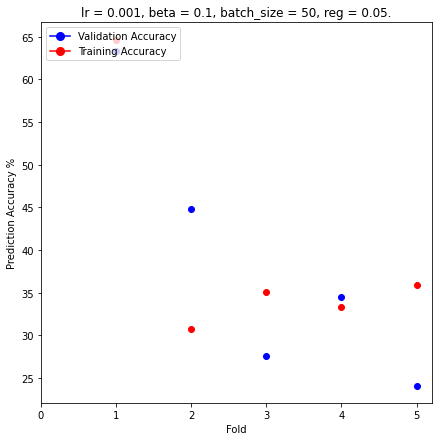


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


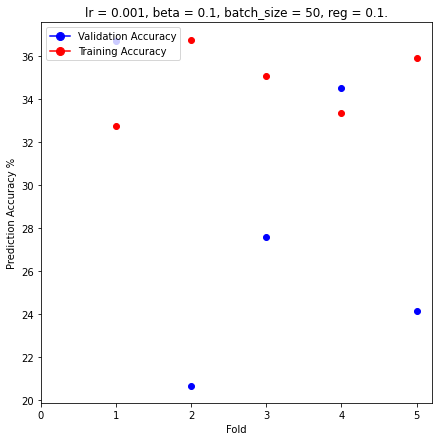


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


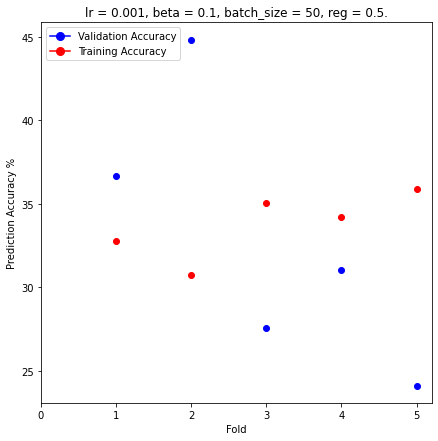


For fold 1 model has validation accuracy 63.33%% and has training accuracy 67.24%
For fold 2 model has validation accuracy 48.28%% and has training accuracy 54.70%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 65.52%% and has training accuracy 63.25%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


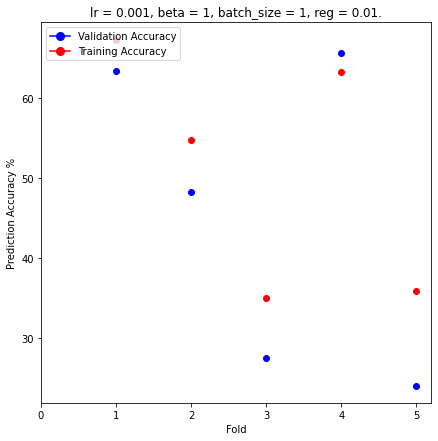


For fold 1 model has validation accuracy 26.67%% and has training accuracy 35.34%
For fold 2 model has validation accuracy 55.17%% and has training accuracy 69.23%
For fold 3 model has validation accuracy 41.38%% and has training accuracy 52.99%
For fold 4 model has validation accuracy 100.00%% and has training accuracy 95.73%
For fold 5 model has validation accuracy 62.07%% and has training accuracy 67.52%


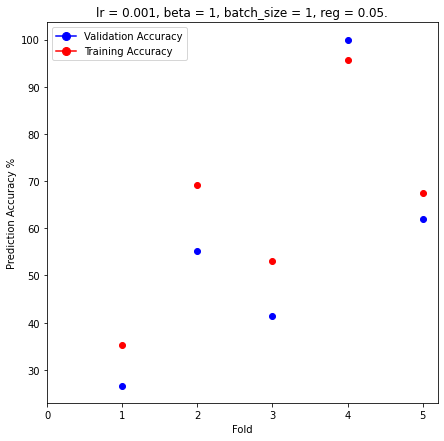


For fold 1 model has validation accuracy 36.67%% and has training accuracy 33.62%
For fold 2 model has validation accuracy 48.28%% and has training accuracy 52.99%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 37.61%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


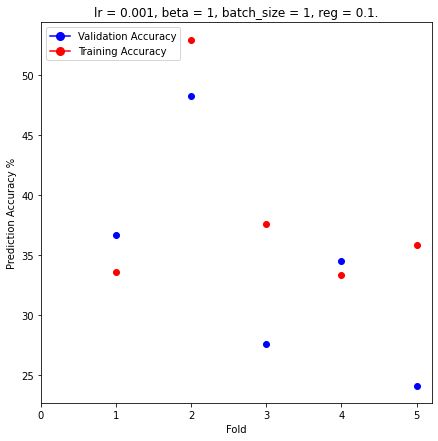


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 34.48%% and has training accuracy 41.88%


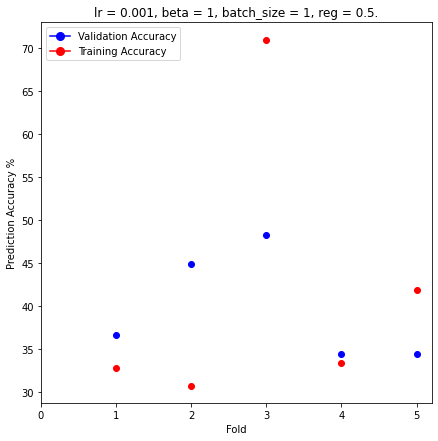


For fold 1 model has validation accuracy 40.00%% and has training accuracy 47.41%
For fold 2 model has validation accuracy 55.17%% and has training accuracy 58.12%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 33.62%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


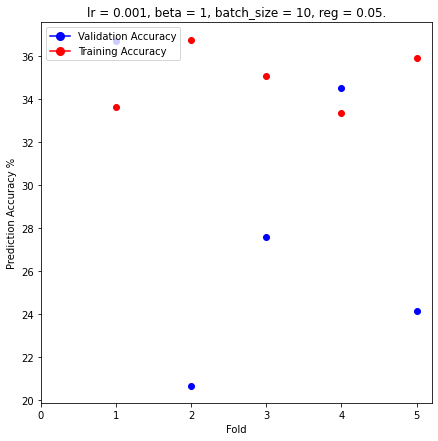


For fold 1 model has validation accuracy 26.67%% and has training accuracy 35.34%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


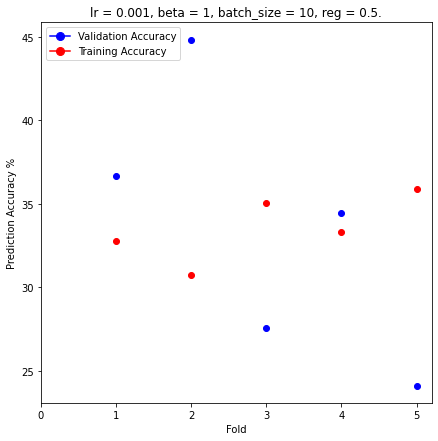


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


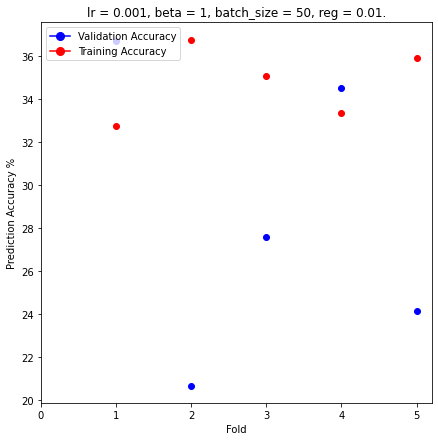


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


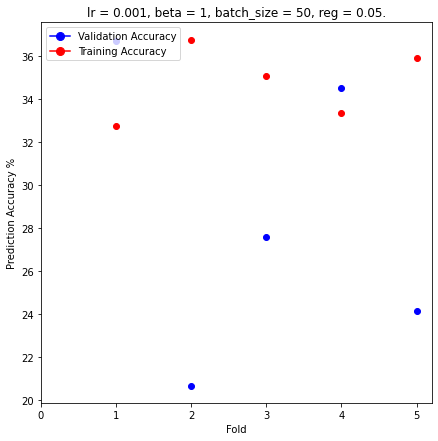


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


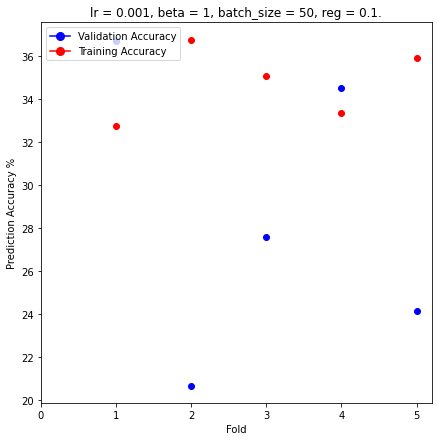


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


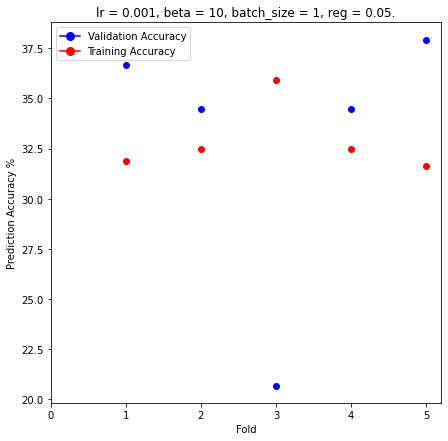


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


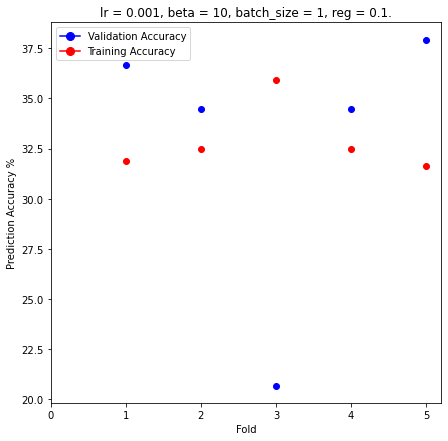


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


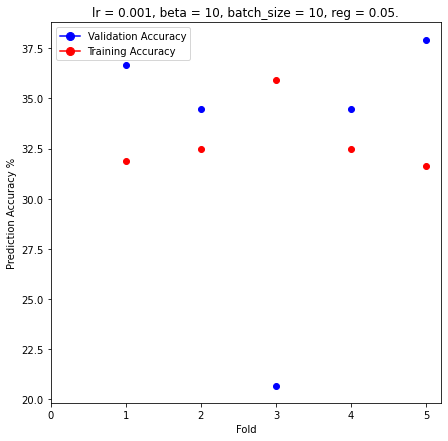


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


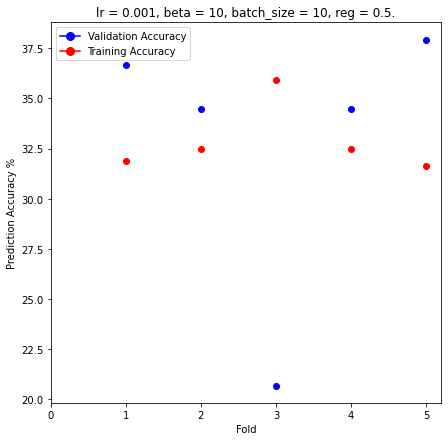


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


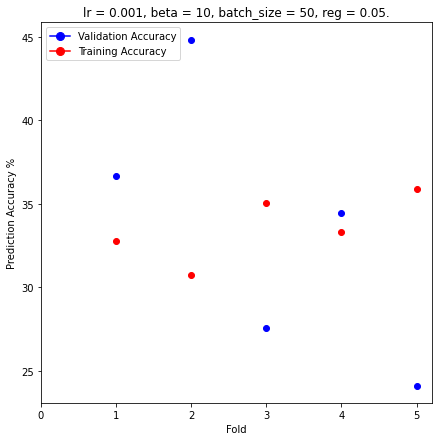


For fold 1 model has validation accuracy 46.67%% and has training accuracy 52.59%
For fold 2 model has validation accuracy 48.28%% and has training accuracy 54.70%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


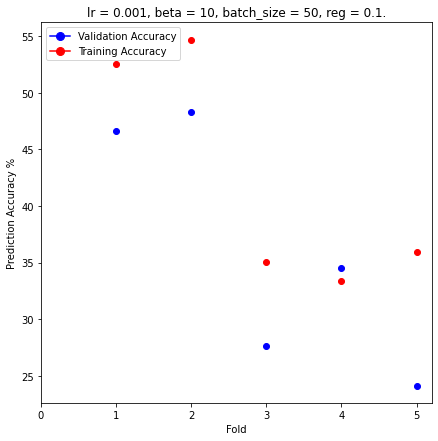


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


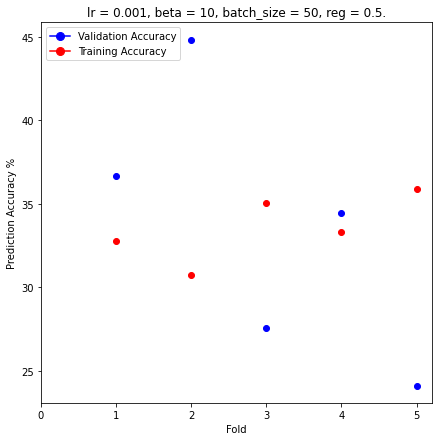


For fold 1 model has validation accuracy 63.33%% and has training accuracy 67.24%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 62.07%% and has training accuracy 67.52%


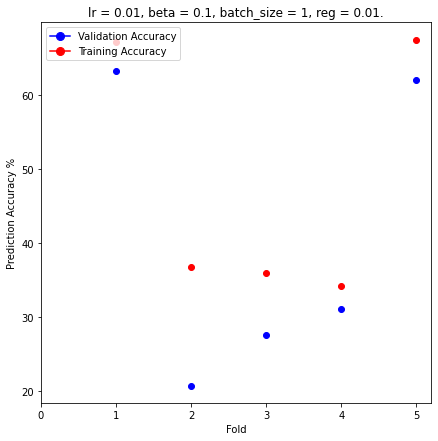


For fold 1 model has validation accuracy 73.33%% and has training accuracy 64.66%
For fold 2 model has validation accuracy 68.97%% and has training accuracy 56.41%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 36.75%


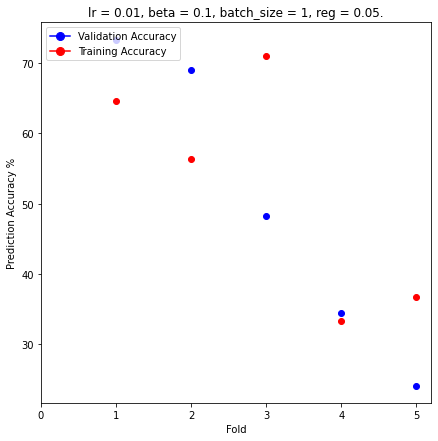


For fold 1 model has validation accuracy 73.33%% and has training accuracy 64.66%
For fold 2 model has validation accuracy 55.17%% and has training accuracy 69.23%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 62.07%% and has training accuracy 67.52%


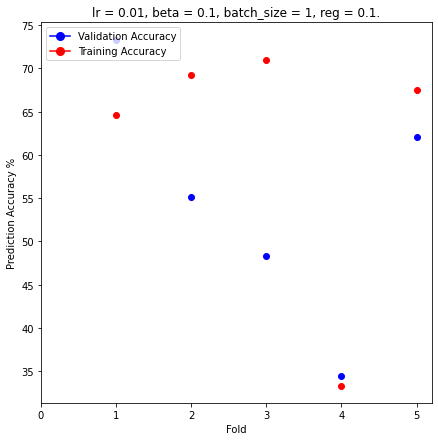


For fold 1 model has validation accuracy 63.33%% and has training accuracy 67.24%
For fold 2 model has validation accuracy 79.31%% and has training accuracy 63.25%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 26.67%% and has training accuracy 35.34%
For fold 2 model has validation accuracy 68.97%% and has training accuracy 65.81%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 41.88%
For fold 5 model has validation accuracy 41.38%% and has training accuracy 55.56%


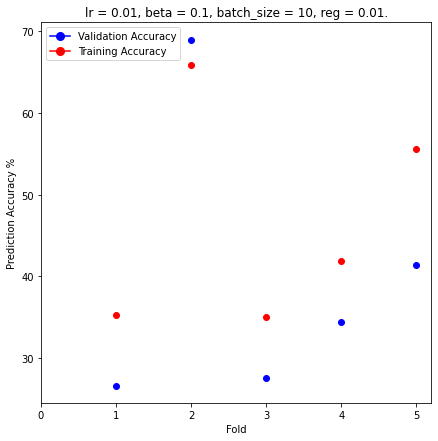


For fold 1 model has validation accuracy 43.33%% and has training accuracy 36.21%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 68.97%% and has training accuracy 65.81%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 60.00%% and has training accuracy 50.00%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 66.67%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


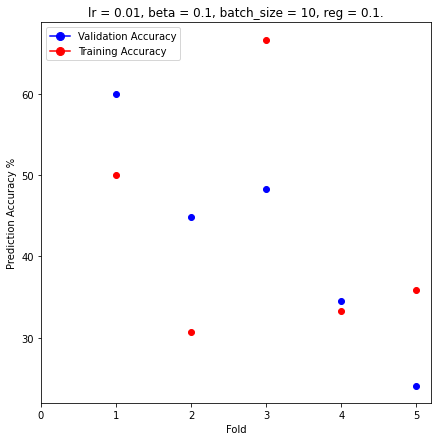


For fold 1 model has validation accuracy 73.33%% and has training accuracy 64.66%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 58.97%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


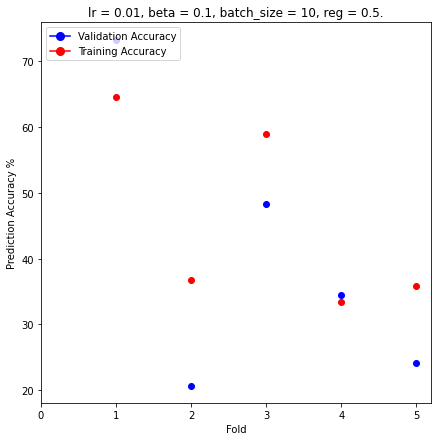


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%



For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


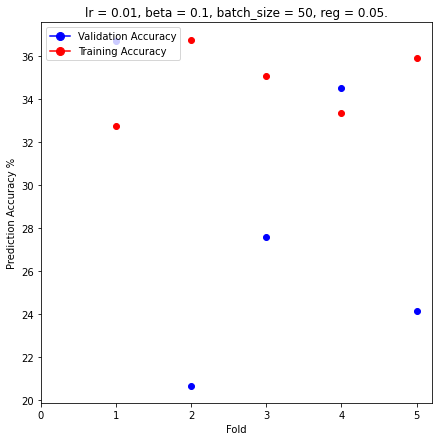


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


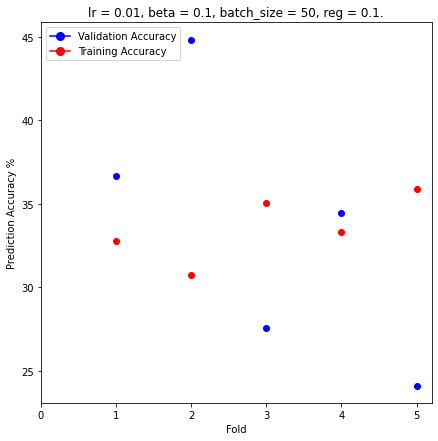


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


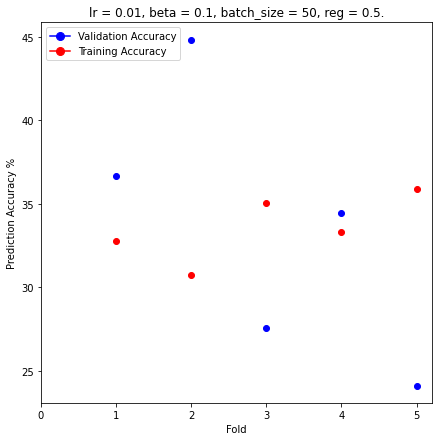


For fold 1 model has validation accuracy 53.33%% and has training accuracy 54.31%
For fold 2 model has validation accuracy 55.17%% and has training accuracy 69.23%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 37.93%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 51.72%% and has training accuracy 57.26%


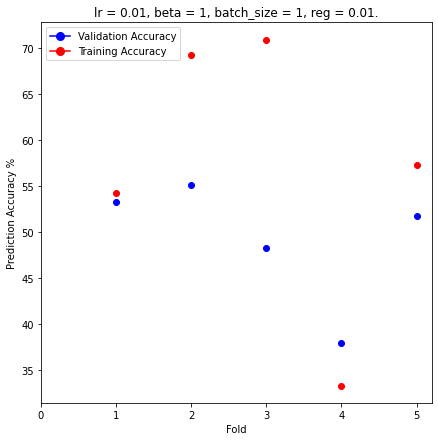


For fold 1 model has validation accuracy 83.33%% and has training accuracy 83.62%
For fold 2 model has validation accuracy 79.31%% and has training accuracy 63.25%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 75.86%% and has training accuracy 64.10%


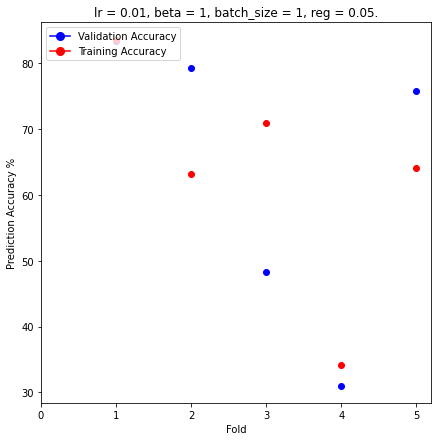


For fold 1 model has validation accuracy 50.00%% and has training accuracy 49.14%
For fold 2 model has validation accuracy 79.31%% and has training accuracy 63.25%
For fold 3 model has validation accuracy 31.03%% and has training accuracy 43.59%
For fold 4 model has validation accuracy 68.97%% and has training accuracy 65.81%
For fold 5 model has validation accuracy 62.07%% and has training accuracy 67.52%


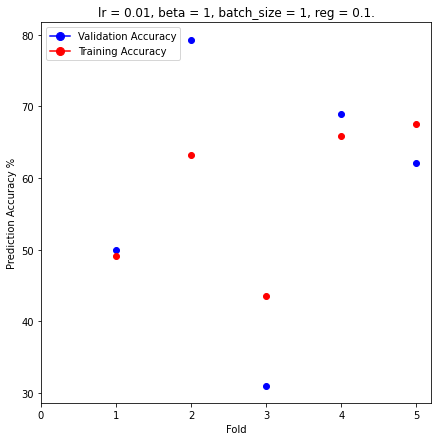


For fold 1 model has validation accuracy 53.33%% and has training accuracy 44.83%
For fold 2 model has validation accuracy 62.07%% and has training accuracy 46.15%
For fold 3 model has validation accuracy 55.17%% and has training accuracy 33.33%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 32.48%


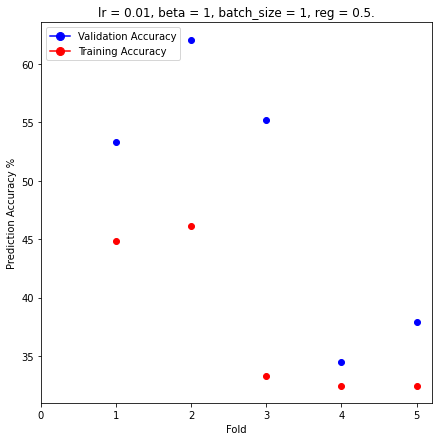


For fold 1 model has validation accuracy 73.33%% and has training accuracy 64.66%
For fold 2 model has validation accuracy 55.17%% and has training accuracy 69.23%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 68.97%% and has training accuracy 65.81%
For fold 5 model has validation accuracy 62.07%% and has training accuracy 67.52%


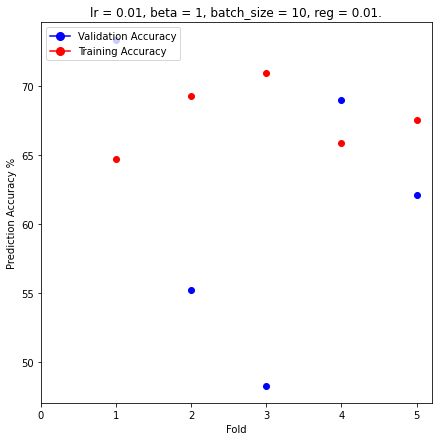


For fold 1 model has validation accuracy 63.33%% and has training accuracy 67.24%
For fold 2 model has validation accuracy 55.17%% and has training accuracy 69.23%
For fold 3 model has validation accuracy 72.41%% and has training accuracy 62.39%
For fold 4 model has validation accuracy 62.07%% and has training accuracy 66.67%
For fold 5 model has validation accuracy 75.86%% and has training accuracy 64.10%


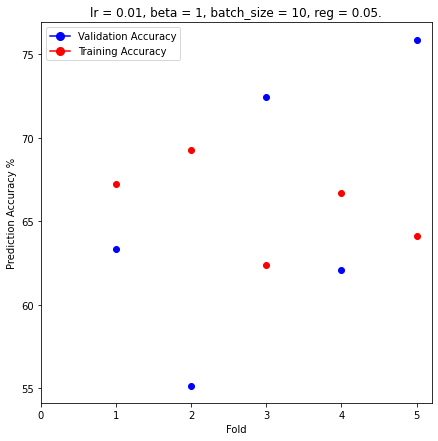


For fold 1 model has validation accuracy 26.67%% and has training accuracy 35.34%
For fold 2 model has validation accuracy 55.17%% and has training accuracy 69.23%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 65.52%% and has training accuracy 66.67%
For fold 5 model has validation accuracy 75.86%% and has training accuracy 64.10%


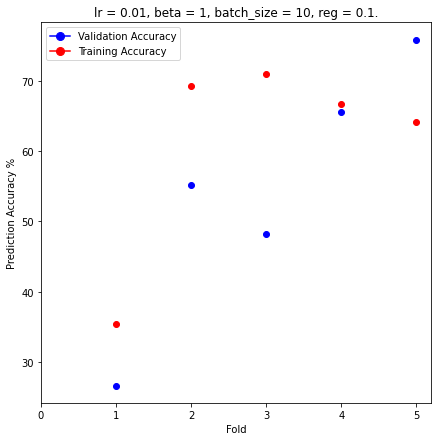


For fold 1 model has validation accuracy 73.33%% and has training accuracy 64.66%
For fold 2 model has validation accuracy 55.17%% and has training accuracy 69.23%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 62.07%% and has training accuracy 65.81%
For fold 5 model has validation accuracy 58.62%% and has training accuracy 65.81%


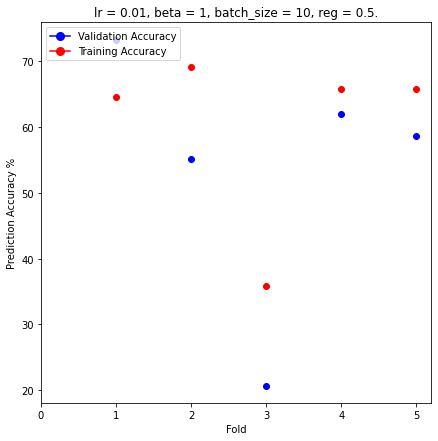


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


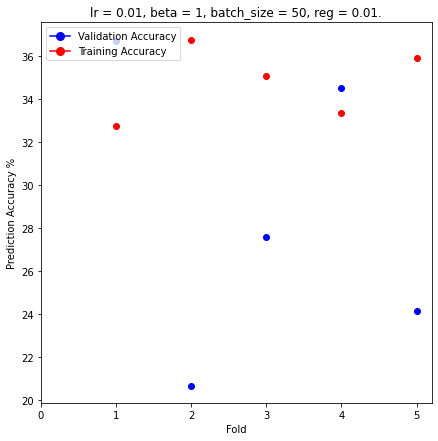


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


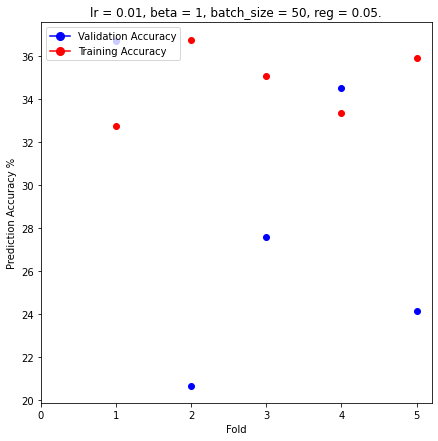


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


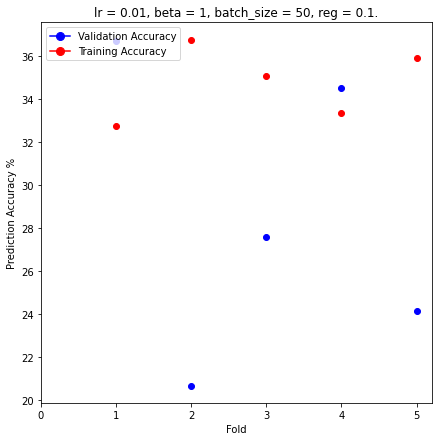


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


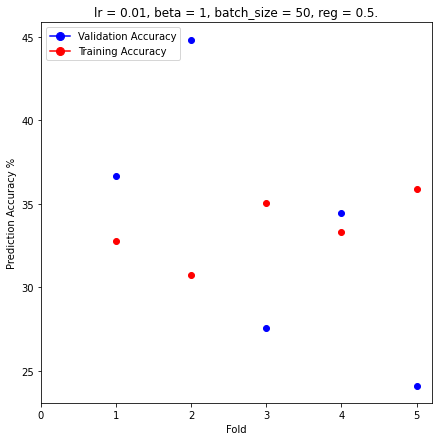


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


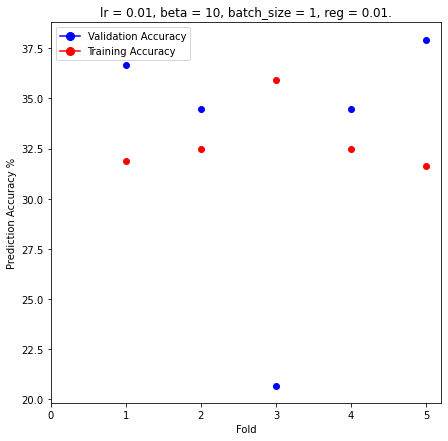


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


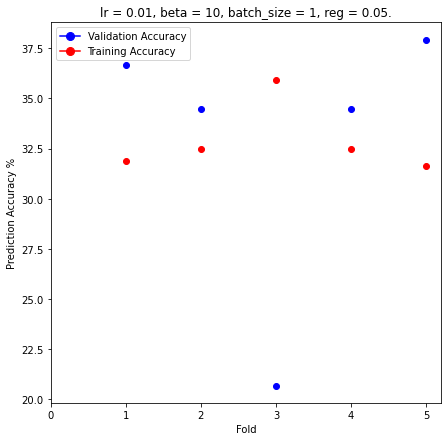


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


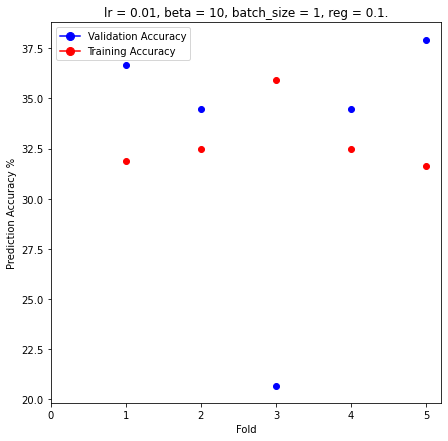


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


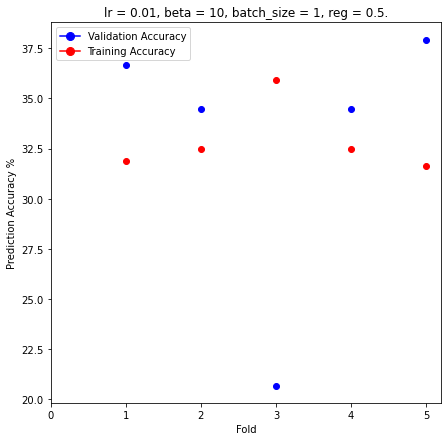


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


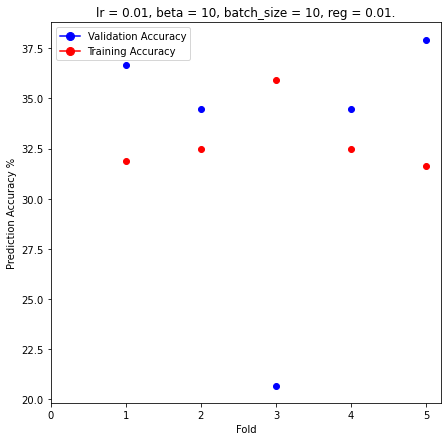


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


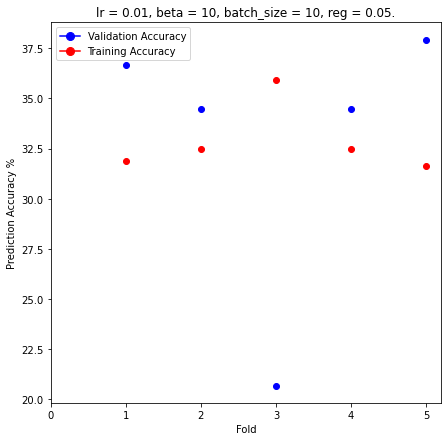


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


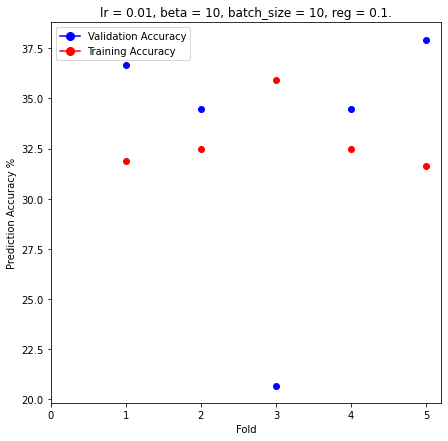


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


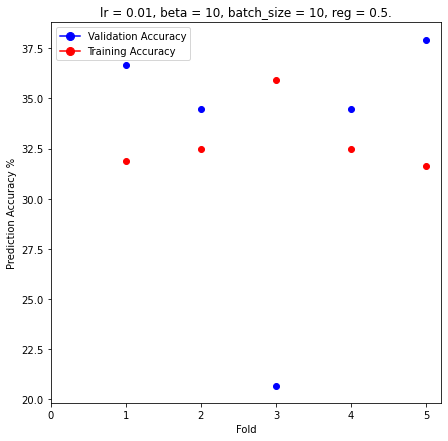


For fold 1 model has validation accuracy 36.67%% and has training accuracy 33.62%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


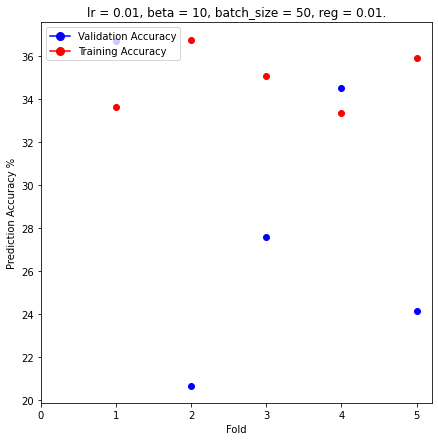


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


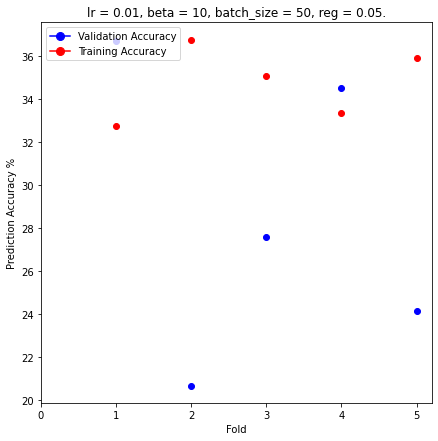


For fold 1 model has validation accuracy 26.67%% and has training accuracy 35.34%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


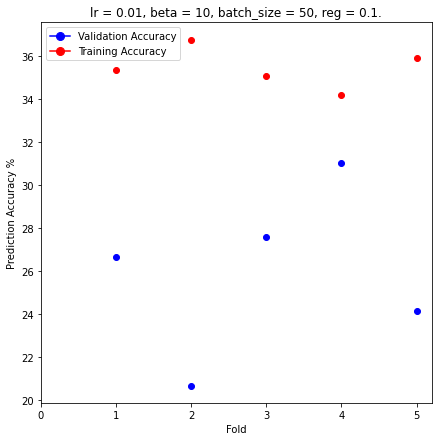


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 32.48%


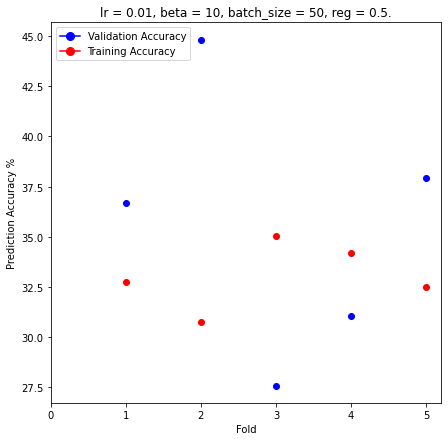


For fold 1 model has validation accuracy 73.33%% and has training accuracy 64.66%
For fold 2 model has validation accuracy 79.31%% and has training accuracy 63.25%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 65.52%% and has training accuracy 66.67%
For fold 5 model has validation accuracy 41.38%% and has training accuracy 36.75%


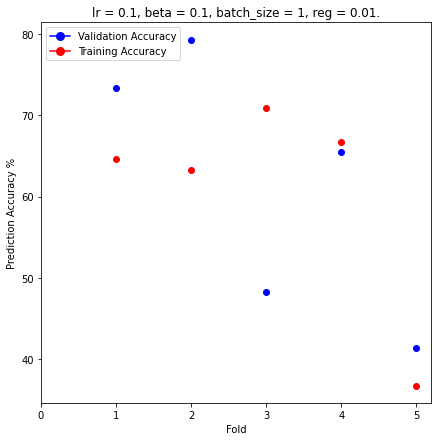


For fold 1 model has validation accuracy 60.00%% and has training accuracy 65.52%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 75.86%% and has training accuracy 64.10%


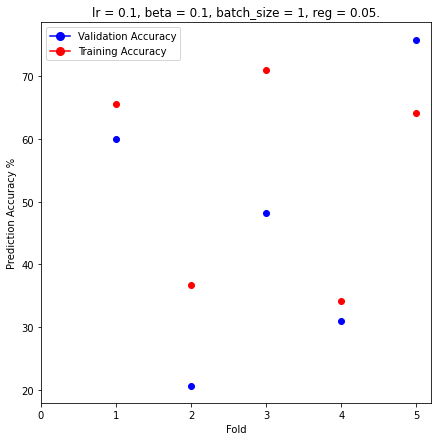


For fold 1 model has validation accuracy 26.67%% and has training accuracy 35.34%
For fold 2 model has validation accuracy 37.93%% and has training accuracy 34.19%
For fold 3 model has validation accuracy 31.03%% and has training accuracy 39.32%
For fold 4 model has validation accuracy 68.97%% and has training accuracy 65.81%
For fold 5 model has validation accuracy 62.07%% and has training accuracy 67.52%


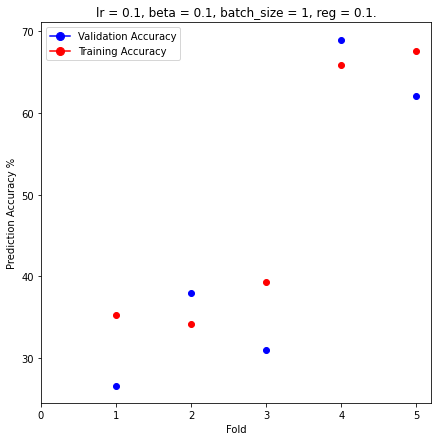


For fold 1 model has validation accuracy 26.67%% and has training accuracy 35.34%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 62.07%% and has training accuracy 67.52%


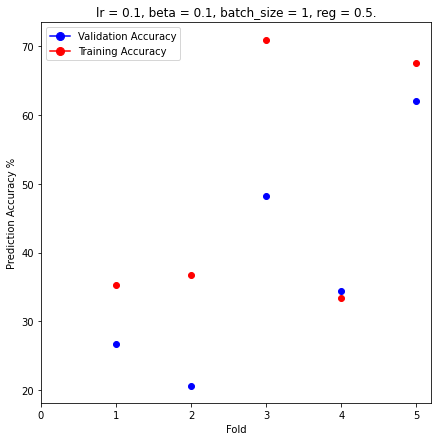


For fold 1 model has validation accuracy 56.67%% and has training accuracy 51.72%
For fold 2 model has validation accuracy 75.86%% and has training accuracy 61.54%
For fold 3 model has validation accuracy 68.97%% and has training accuracy 47.01%
For fold 4 model has validation accuracy 68.97%% and has training accuracy 65.81%
For fold 5 model has validation accuracy 41.38%% and has training accuracy 34.19%


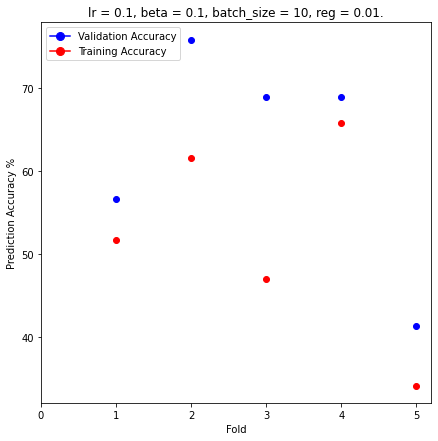


For fold 1 model has validation accuracy 73.33%% and has training accuracy 64.66%
For fold 2 model has validation accuracy 55.17%% and has training accuracy 69.23%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 65.52%% and has training accuracy 66.67%
For fold 5 model has validation accuracy 62.07%% and has training accuracy 67.52%


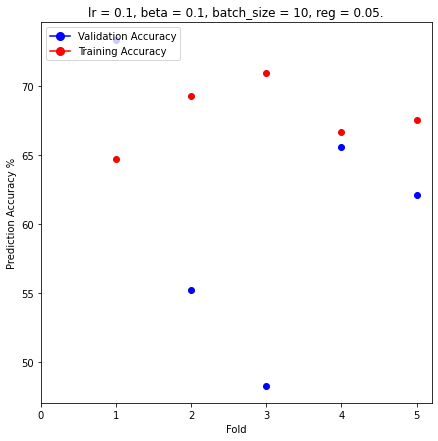


For fold 1 model has validation accuracy 36.67%% and has training accuracy 34.48%
For fold 2 model has validation accuracy 82.76%% and has training accuracy 75.21%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 36.75%
For fold 4 model has validation accuracy 62.07%% and has training accuracy 64.96%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 34.19%


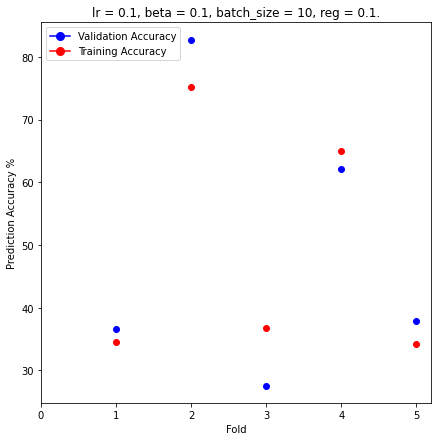


For fold 1 model has validation accuracy 26.67%% and has training accuracy 37.07%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 51.72%% and has training accuracy 47.01%


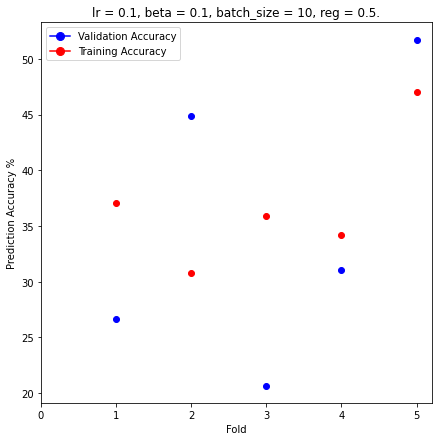


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 44.83%% and has training accuracy 61.54%


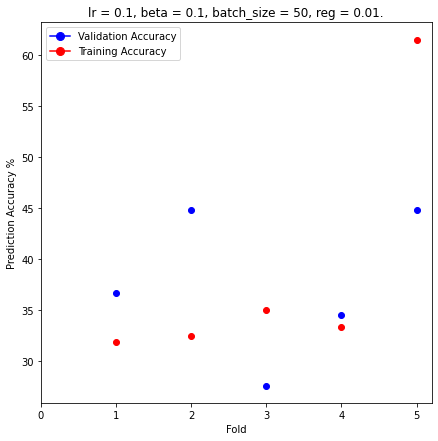


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 41.38%% and has training accuracy 43.59%
For fold 4 model has validation accuracy 62.07%% and has training accuracy 66.67%
For fold 5 model has validation accuracy 44.83%% and has training accuracy 35.04%


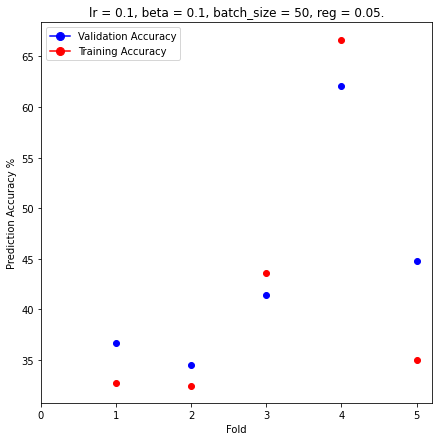


For fold 1 model has validation accuracy 73.33%% and has training accuracy 64.66%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


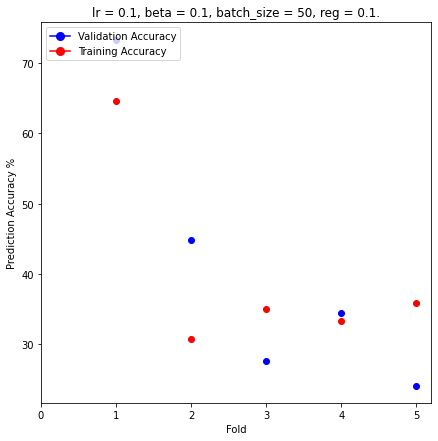


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 55.17%% and has training accuracy 29.91%
For fold 4 model has validation accuracy 65.52%% and has training accuracy 66.67%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


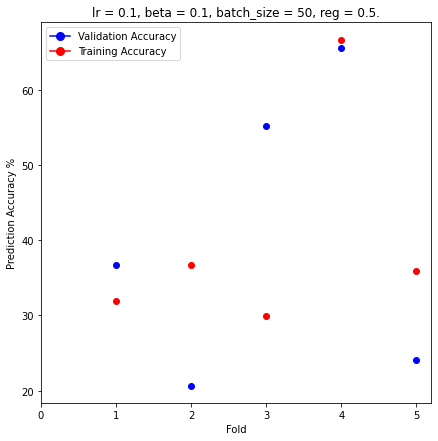


For fold 1 model has validation accuracy 53.33%% and has training accuracy 53.45%
For fold 2 model has validation accuracy 62.07%% and has training accuracy 48.72%
For fold 3 model has validation accuracy 51.72%% and has training accuracy 29.06%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 35.90%
For fold 5 model has validation accuracy 62.07%% and has training accuracy 67.52%


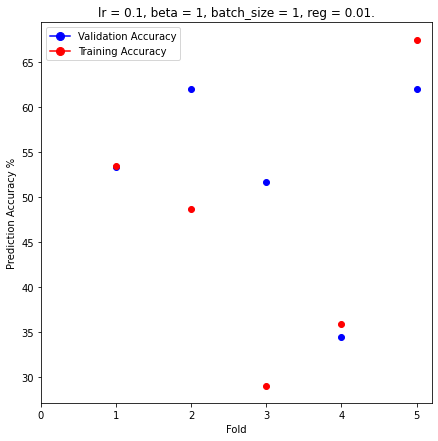


For fold 1 model has validation accuracy 73.33%% and has training accuracy 64.66%
For fold 2 model has validation accuracy 79.31%% and has training accuracy 63.25%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 65.52%% and has training accuracy 66.67%
For fold 5 model has validation accuracy 75.86%% and has training accuracy 64.10%


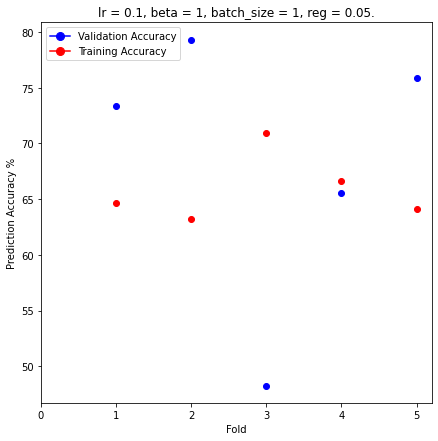


For fold 1 model has validation accuracy 26.67%% and has training accuracy 35.34%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 38.46%
For fold 3 model has validation accuracy 51.72%% and has training accuracy 29.06%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 62.07%% and has training accuracy 67.52%


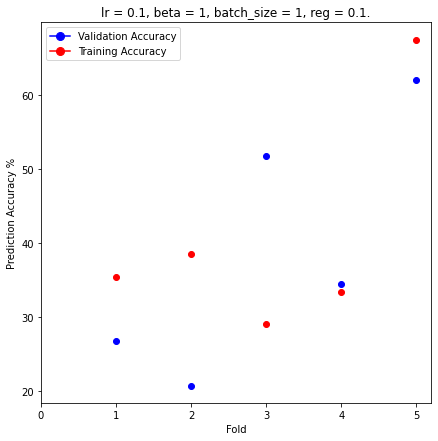


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 62.07%% and has training accuracy 67.52%


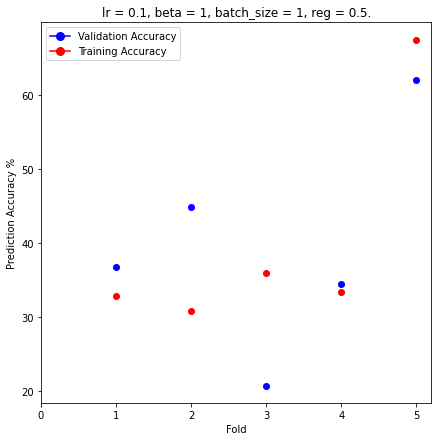


For fold 1 model has validation accuracy 63.33%% and has training accuracy 67.24%
For fold 2 model has validation accuracy 79.31%% and has training accuracy 63.25%
For fold 3 model has validation accuracy 55.17%% and has training accuracy 33.33%
For fold 4 model has validation accuracy 65.52%% and has training accuracy 66.67%
For fold 5 model has validation accuracy 68.97%% and has training accuracy 59.83%


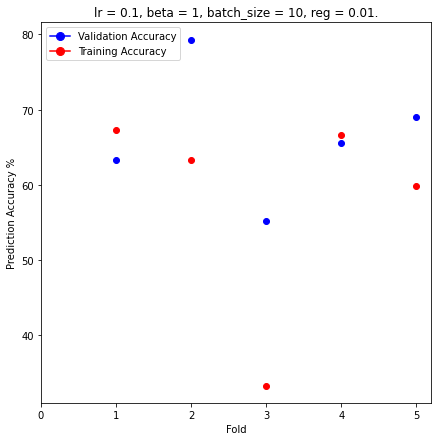


For fold 1 model has validation accuracy 63.33%% and has training accuracy 67.24%
For fold 2 model has validation accuracy 24.14%% and has training accuracy 41.03%
For fold 3 model has validation accuracy 96.55%% and has training accuracy 95.73%
For fold 4 model has validation accuracy 65.52%% and has training accuracy 66.67%
For fold 5 model has validation accuracy 62.07%% and has training accuracy 67.52%


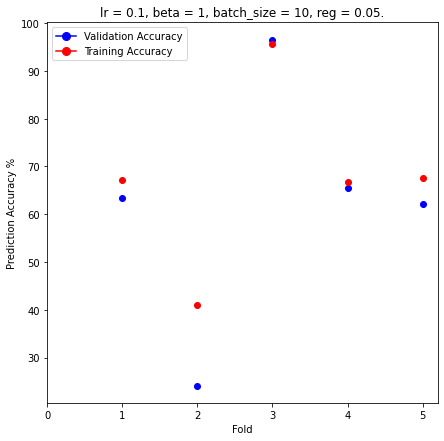


For fold 1 model has validation accuracy 73.33%% and has training accuracy 64.66%
For fold 2 model has validation accuracy 55.17%% and has training accuracy 69.23%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 68.38%
For fold 4 model has validation accuracy 55.17%% and has training accuracy 66.67%
For fold 5 model has validation accuracy 62.07%% and has training accuracy 67.52%


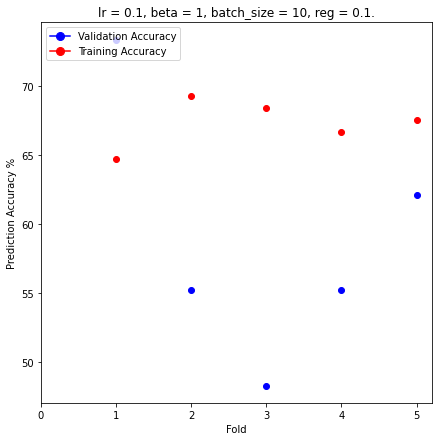


For fold 1 model has validation accuracy 63.33%% and has training accuracy 65.52%
For fold 2 model has validation accuracy 79.31%% and has training accuracy 63.25%
For fold 3 model has validation accuracy 72.41%% and has training accuracy 64.96%
For fold 4 model has validation accuracy 68.97%% and has training accuracy 65.81%
For fold 5 model has validation accuracy 62.07%% and has training accuracy 67.52%


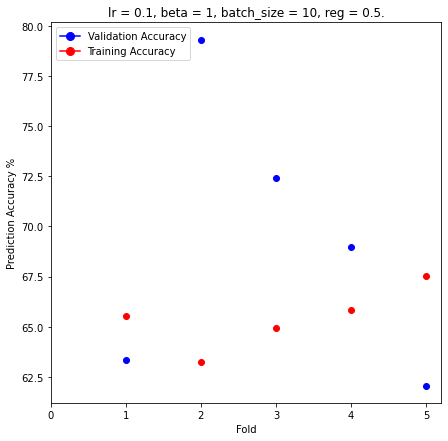


For fold 1 model has validation accuracy 73.33%% and has training accuracy 64.66%
For fold 2 model has validation accuracy 55.17%% and has training accuracy 69.23%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 65.52%% and has training accuracy 66.67%
For fold 5 model has validation accuracy 41.38%% and has training accuracy 33.33%


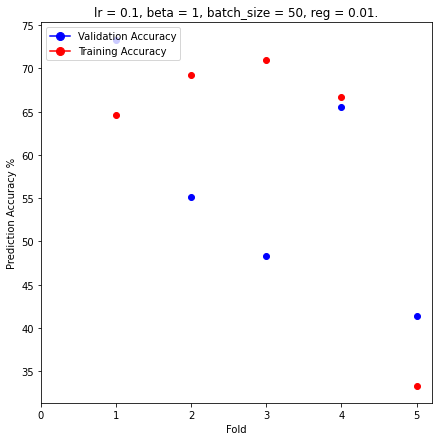


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 79.31%% and has training accuracy 63.25%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 100.00%% and has training accuracy 97.44%


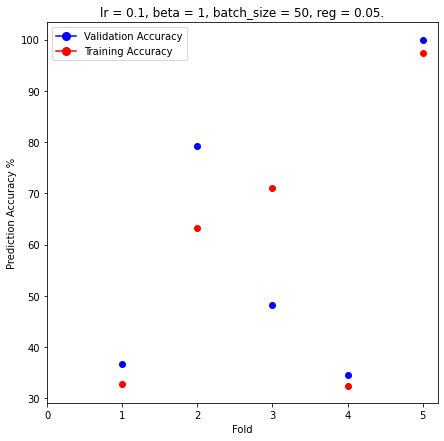


For fold 1 model has validation accuracy 73.33%% and has training accuracy 64.66%
For fold 2 model has validation accuracy 55.17%% and has training accuracy 69.23%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 68.97%% and has training accuracy 65.81%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 32.48%


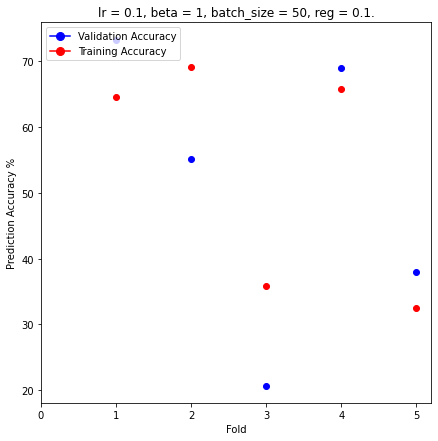


For fold 1 model has validation accuracy 50.00%% and has training accuracy 50.00%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 37.61%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 79.31%% and has training accuracy 76.92%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


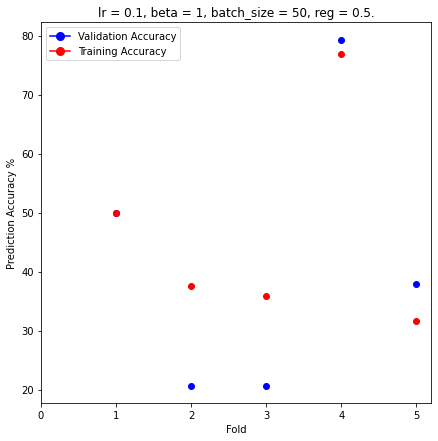


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


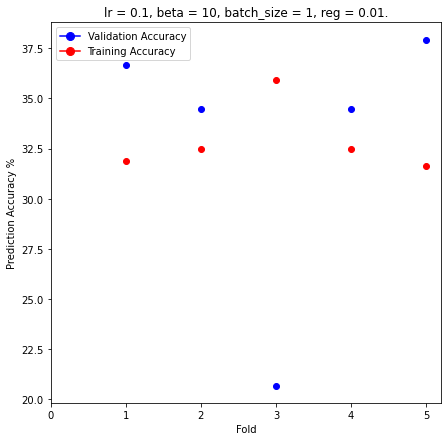


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


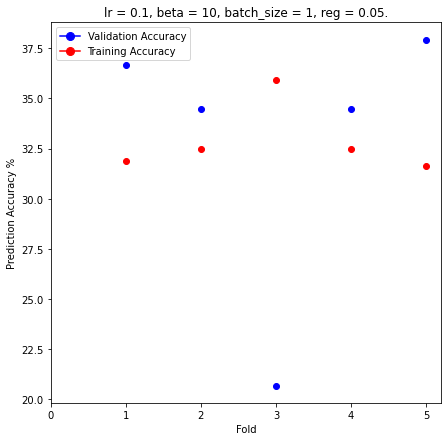


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


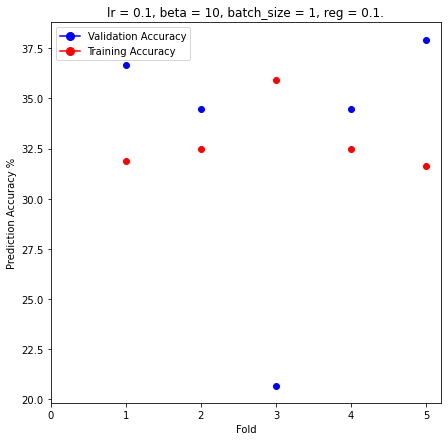


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


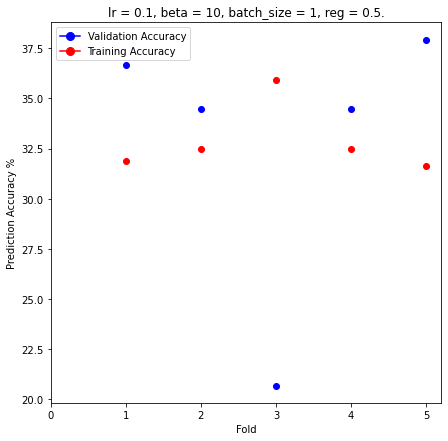


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


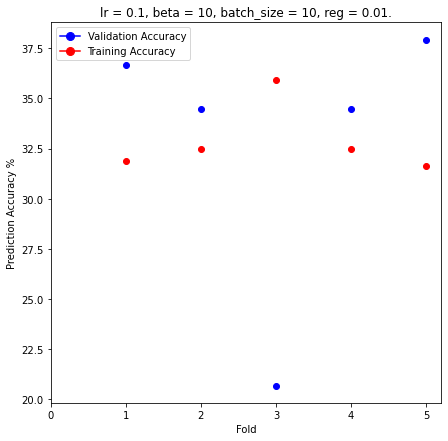


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


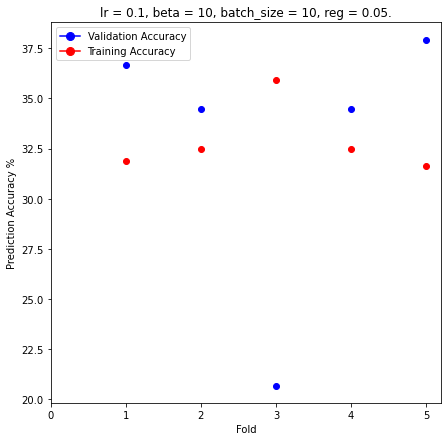


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


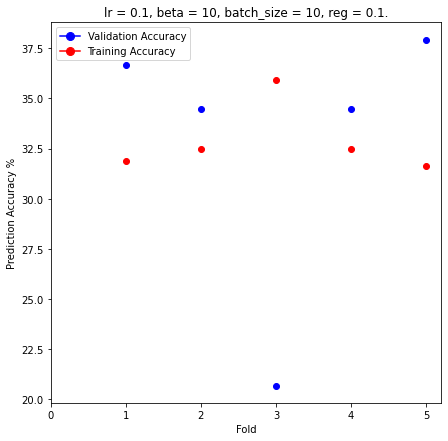


For fold 1 model has validation accuracy 36.67%% and has training accuracy 31.90%
For fold 2 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 3 model has validation accuracy 20.69%% and has training accuracy 35.90%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 32.48%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 31.62%


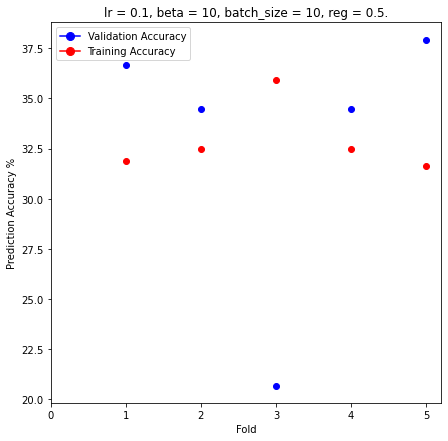


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 48.28%% and has training accuracy 70.94%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 37.93%% and has training accuracy 32.48%


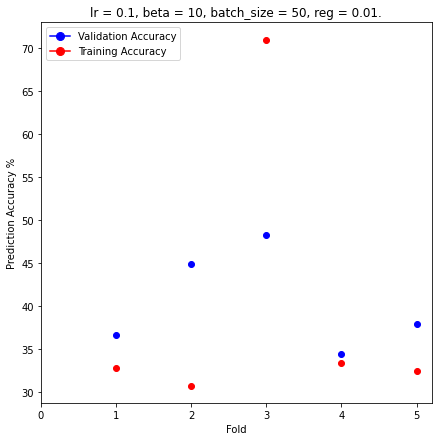


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 31.03%% and has training accuracy 34.19%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


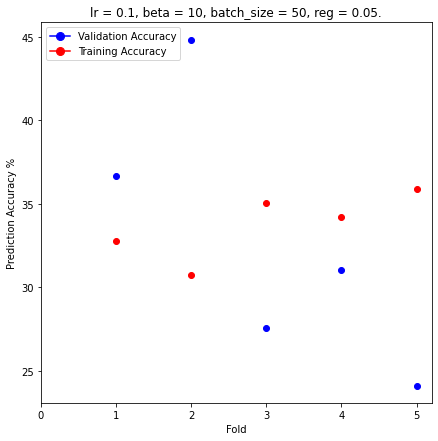


For fold 1 model has validation accuracy 26.67%% and has training accuracy 35.34%
For fold 2 model has validation accuracy 20.69%% and has training accuracy 36.75%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 34.48%% and has training accuracy 33.33%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


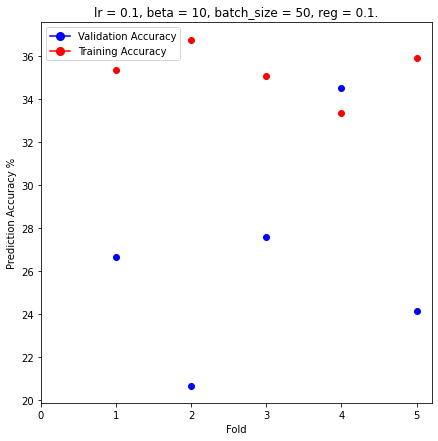


For fold 1 model has validation accuracy 36.67%% and has training accuracy 32.76%
For fold 2 model has validation accuracy 44.83%% and has training accuracy 30.77%
For fold 3 model has validation accuracy 27.59%% and has training accuracy 35.04%
For fold 4 model has validation accuracy 68.97%% and has training accuracy 70.94%
For fold 5 model has validation accuracy 24.14%% and has training accuracy 35.90%


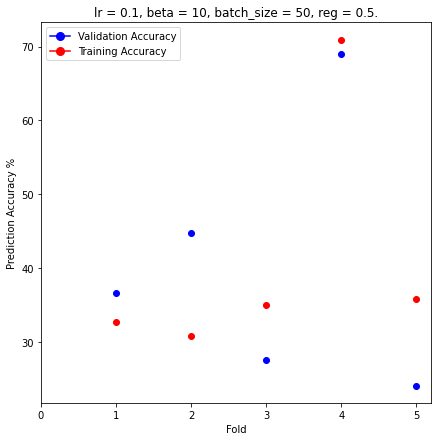


Highest mean validation accuracy was 0.692183908045977. Params were LR: 0.1, Beta: 1, BatchSize: 10, Reg: 0.5


In [ ]:
#Hyperparameter tuning for digits dataset
learning_rate = [0.0001, 0.001, 0.01, 0.1]
beta = [0.1, 1, 10]
batch_size = [1, 10, 50]
reg = [0.01, 0.05, 0.1, 0.5]

maxValidationAccuracy = 0
params = (0,0,0,0)

for lr in learning_rate:
  for b in beta:
    for batch in batch_size:
      for r in reg:
        accuracyValid, accuracyTrain = modelExecution(irisFolds, lr, b, batch, r)
        plt.figure(figsize=(7,7))
        for i in range(len(accuracyValid)):
          print("For fold "+str(i+1)+" model has validation accuracy {:.2%}".format(accuracyValid[i])+"% "+"and has training accuracy {:.2%}".format(accuracyTrain[i]))
          
          #Create the grapghs as we loop through the different params
          plt.scatter(i+1, accuracyValid[i] * 100, c = "Blue", label = "Validation Accuracy")
          plt.scatter(i+1, accuracyTrain[i] * 100, c = "Red", label = "Training Accuracy")
        
        #Keep track of params with highest mean validation accuracy
        if maxValidationAccuracy < (sum(accuracyValid)/5):
          maxValidationAccuracy = sum(accuracyValid)/5
          params = (lr, b, batch, r)

        #Print the scatter plot
        plt.xlabel("Fold")
        plt.xticks([0,1,2,3,4,5])
        plt.ylabel("Prediction Accuracy %")
        plt.title("lr = "+str(lr)+", beta = "+str(b)+", batch_size = "+str(batch)+", reg = "+str(r)+".")
        plt.legend(handles = legend_elements, loc = 2)
        plt.show()

        print()

bestLR_iris, bestB_iris, bestBatch_iris, bestR_iris = params
print("Highest mean validation accuracy was "+str(maxValidationAccuracy)+". Params were LR: "+str(bestLR_iris)+", Beta: "+str(bestB_iris)+", BatchSize: "+str(bestBatch_iris)+", Reg: "+str(bestR_iris))

##Termination Condition
Tracking the training and validation accuracy in each iteration of the set. 

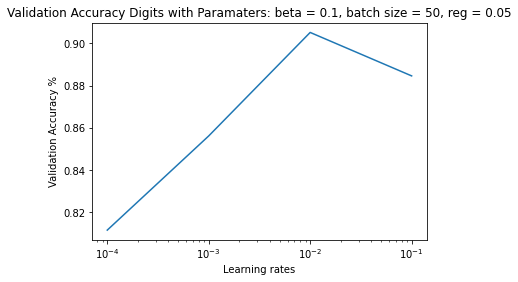

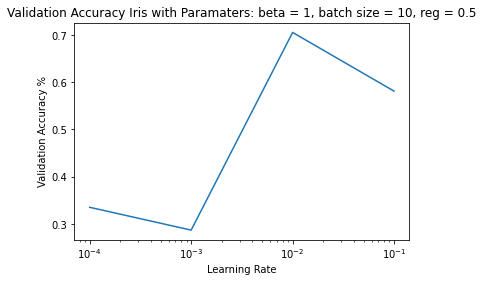

In [ ]:
#Selecting the best hyperparameters which give the best accuracy in digits
beta = bestB_digits
batch_size = bestBatch_digits
reg = bestR_digits


learning =[0.0001, 0.001, 0.01, 0.1] #different learning rates
accurArray = []
for l in learning:
    accuracyValid, accuracyTrain = modelExecution(digitFolds, l, beta, batch_size, reg)
    accurArray.append(sum(accuracyValid)/5)

plt.plot(learning, accurArray)
plt.xlabel("Learning rates")
plt.xticks(learning)
plt.xscale('log')
plt.ylabel("Validation Accuracy %")
plt.title("Validation Accuracy Digits with Paramaters: beta = "+str(beta)+", batch size = "+str(batch_size)+", reg = "+str(reg))
plt.show()

#Iris here
beta = bestB_iris
batch_size = bestBatch_iris
reg = bestR_iris

accurArray = []
for l in learning:
  accuracyValid, accuracyTrain = modelExecution(irisFolds, l, beta, batch_size, reg)
  accurArray.append(sum(accuracyValid)/5)

plt.plot(learning, accurArray)
plt.xlabel("Learning Rate")
plt.xticks(learning)
plt.xscale("log")
plt.ylabel("Validation Accuracy %")
plt.title("Validation Accuracy Iris with Paramaters: beta = "+str(beta)+", batch size = "+str(batch_size)+", reg = "+str(reg))
plt.show()

##Comparison against another classifier

In [ ]:
def knnClassifier(k, dataset):
  accuracy = []
  for neighbors in k:
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    #Store accuracy of the 5 folds
    fold_accuracy = []

    for i in range(5):
      validData, validTarget = dataset[i]

      #Combine the other 4 folds to form training set
      trainData = []
      trainTarget = []
      for j in range(5):
        if i != j:
          tempData, tempTarget = dataset[j]
          trainData.extend(tempData)
          trainTarget.extend(tempTarget)

      #Fit knn to training data
      knn.fit(trainData, trainTarget)

      #Determine accuracy of fit
      correct = 0
      for j in range(len(validTarget)):
        prediction = knn.predict(validData[j].reshape(1,-1))
        if prediction == validTarget[j]:
          correct += 1
    
      #Add the accuracy per fold to fold_accuracy
      fold_accuracy.append(correct/len(validTarget))

    #Before we test the next value of K, sum the fold accuracies and divide by 5 to get the mean accuracy per value of K
    accuracy.append(sum(fold_accuracy)/5)

  return accuracy

For Digits, K = 1, mean accuracy of 98.88%
For Digits, K = 2, mean accuracy of 98.66%
For Digits, K = 3, mean accuracy of 98.72%
For Digits, K = 4, mean accuracy of 98.55%
For Digits, K = 5, mean accuracy of 98.77%
For Digits, K = 6, mean accuracy of 98.49%
For Digits, K = 7, mean accuracy of 98.55%
For Digits, K = 8, mean accuracy of 98.49%
For Digits, K = 9, mean accuracy of 98.38%
For Digits, K = 10, mean accuracy of 97.99%
For Digits, K = 11, mean accuracy of 98.16%
For Digits, K = 12, mean accuracy of 97.99%
For Digits, K = 13, mean accuracy of 97.99%
For Digits, K = 14, mean accuracy of 97.88%
For Digits, K = 15, mean accuracy of 97.88%
For Digits, K = 16, mean accuracy of 97.60%
For Digits, K = 17, mean accuracy of 97.66%
For Digits, K = 18, mean accuracy of 97.38%
For Digits, K = 19, mean accuracy of 97.43%
For Digits, K = 20, mean accuracy of 97.21%
For Digits, K = 21, mean accuracy of 97.04%
For Digits, K = 22, mean accuracy of 96.82%
For Digits, K = 23, mean accuracy of 96.8

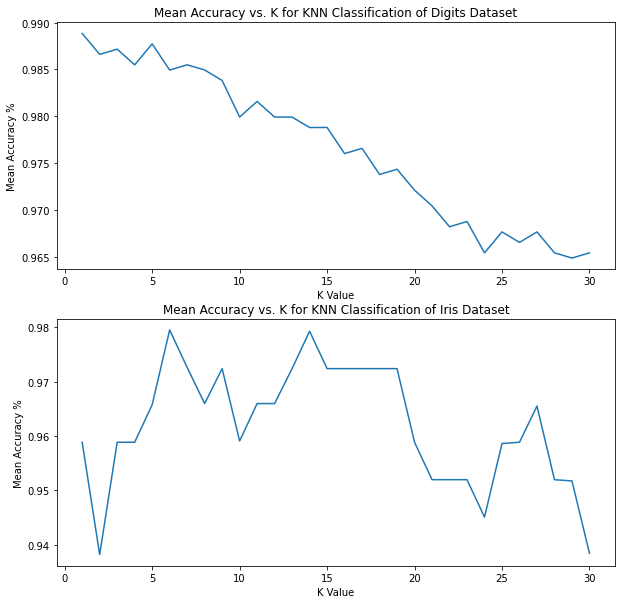

In [ ]:
#Run KNN on digits dataset, we will test different values of K to see which 
#returns the highest results
numK=31

#Set up values of k to iterate through
k = []
for i in range(1,numK):
  k.append(i)

accuracyDigits = knnClassifier(k, digitFolds)
accuracyIris = knnClassifier(k, irisFolds)


for i in range(len(accuracyDigits)):
  print("For Digits, K = "+str(i+1)+", mean accuracy of {:.2%}".format(accuracyDigits[i]))

print("Highest digit accuracy with k ="+str(np.argmax(accuracyDigits) + 1))
print()

for i in range(len(accuracyIris)):
  print("For Iris, K = "+str(i+1)+", mean accuracy of {:.2%}".format(accuracyDigits[i]))

print("Highest iris accuracy with k ="+str(np.argmax(accuracyIris) + 1))

plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot(k, accuracyDigits)
plt.xlabel("K Value")
plt.ylabel("Mean Accuracy %")
plt.title("Mean Accuracy vs. K for KNN Classification of Digits Dataset")

plt.subplot(2,1,2)
plt.plot(k, accuracyIris)
plt.xlabel("K Value")
plt.ylabel("Mean Accuracy %")
plt.title("Mean Accuracy vs. K for KNN Classification of Iris Dataset")

plt.show()